<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Abstract</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Notes-to-self:" data-toc-modified-id="Notes-to-self:-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Notes to self:</a></span></li><li><span><a href="#Thoughts" data-toc-modified-id="Thoughts-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Thoughts</a></span></li><li><span><a href="#To-Do:" data-toc-modified-id="To-Do:-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>To Do:</a></span></li></ul></li></ul></li><li><span><a href="#Background-Functions" data-toc-modified-id="Background-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background Functions</a></span><ul class="toc-item"><li><span><a href="#Constants" data-toc-modified-id="Constants-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Constants</a></span></li><li><span><a href="#General-Functions" data-toc-modified-id="General-Functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>General Functions</a></span></li><li><span><a href="#Output-Functions" data-toc-modified-id="Output-Functions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Output Functions</a></span></li><li><span><a href="#Sub-Routines" data-toc-modified-id="Sub-Routines-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Sub-Routines</a></span></li><li><span><a href="#Main-Routines" data-toc-modified-id="Main-Routines-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Main Routines</a></span></li><li><span><a href="#Interpolation-Example" data-toc-modified-id="Interpolation-Example-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Interpolation Example</a></span></li></ul></li><li><span><a href="#Project-Spec" data-toc-modified-id="Project-Spec-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Project Spec</a></span></li><li><span><a href="#Basic-Range-Reduction" data-toc-modified-id="Basic-Range-Reduction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Basic Range Reduction</a></span></li><li><span><a href="#Variance-Reduction---&quot;Smoothing&quot;" data-toc-modified-id="Variance-Reduction---&quot;Smoothing&quot;-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Variance Reduction - "Smoothing"</a></span></li></ul></div>

In [1]:
# To initialise all the libraries you need for this notebook run the below code.
# This is to be used when you are jumping through the document

import numpy as np
from numpy import sin, cos, exp, pi, log, log10, ceil, mean
np.set_printoptions(precision=6, suppress=True, threshold=10)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 3)
import matplotlib.style as plt_style
plt_style.use("ggplot")
import matplotlib.dates as mdates

import csv
import datetime as dt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

# <center> UNIVERSITY COLLEGE DUBLIN </center> <a class="tocSkip">
# <center> SCHOOL OF ELECTRICAL, ELECTRONIC & COMMUNICATIONS ENG. </center> <a class="tocSkip">
## <center> FINAL YEAR PROJECT</center> <a class="tocSkip">
# <center> Electric Vehicles and the Grid </center> <a class="tocSkip">

Report by: 


<center>James Carron:  15333196

# Abstract

With so many Electric Vehicles set to join the grid in upcoming years its is critical that we plan now for how they will effect our energy grid in the future. There are a whole new set of challenges and opportunities including demand response, increased local strain on the network and peer to peer energy trading.

In this project I employ some basic modelling to investigate the possibility of using the battery capacity of dormant electric vehicles connected to the grid as demand response to counteract the instability brought on to the grid by renewable energy. Thus allowing for reduced curtailment losses, increased fossil fuel plan efficiency and increased reliability and robustness

### Notes to self:
 - All values are in MW or MWh

### Thoughts
- How do we invert the power from the batteries? Will this be something the manufacturer has to implement?
- Inverter in the car or charger? Cost, Size etc

### To Do: 
- Investigate losses in the system and account for them

# Background Functions

## Constants

In [2]:
SEC_IN_MIN = 60
SEC_IN_HR = 60 * SEC_IN_MIN
SEC_IN_DAY = 24 * SEC_IN_HR

## General Functions

In [3]:
def IntersectionPoint(data_x, data_y, line, tolerance=50):
    intersections = list()

    prevdist = abs(data_y[0] - line)
    prevValue = False

    for index, value in enumerate(data_y[1:]):

        distance = abs(value - line)

        if distance < prevdist:
            decreasing = True
        if distance > prevdist:
            decreasing = False

        if prevValue == True and decreasing == False and prevdist < tolerance:
            intersections.append(data_x[index - 1])

        prevValue = decreasing
        prevdist = distance

    return intersections


def CrossOverPoints(data_x, data_y, line, above, DEBUG=False):
    intersections = list()
    i = 0

    for i, value in enumerate(data_y[i:]):  # check all values
        if above == False:  # if we expect the point to be below the line
            # find cross up point
            if DEBUG:
                print("{}: below".format(data_x[i].time()))
            if value > line:
                above = True
                intersections.append(data_x[i])
        # else lets start here
        else:  # find cross down point
            if DEBUG:
                print("{}: above".format(data_x[i].time()))
            if value < line:
                above = False
                intersections.append(data_x[i])
    return intersections


def area_between_curves(data1_y, data2_y, interval, above=None, DEBUG=False):
    """Calculates the area between curves 
    Additional argument above to only count areas where data1_y is above data2_y if True and below if False, 
    Default value None counts all area between curves
    Curve is passed as first argument and line as second. Two curves can also be passed"""

    if DEBUG:
        print("Data1_y Type: {}, \t Data2_y: {}".format(
            type(data1_y).__name__,
            type(data2_y).__name__))

    area = 0.0

    data2_y_type = type(data2_y).__name__

    # Comparing two curves
    if data2_y_type == "list" or data2_y_type == "ndarray":

        # Ensure lists are the same size
        if len(data1_y) != len(data2_y):
            print("ERROR: ARRAYS ARE NOT THE SAME SIZE")
            return -1

        if above == None:
            for val1, val2 in zip(data1_y, data2_y):
                area += abs(val1 - val2)

        if above == True:
            for val1, val2 in zip(data1_y, data2_y):
                if val1 > val2:
                    area += val1 - val2
                    # print(area)

        if above == False:
            for val1, val2 in zip(data1_y, data2_y):
                if val1 < val2:
                    area += val2 - val1

    # Comparing a curve to a straightline
    else:  # if data2_y_type == "int" or data2_y_type =="float" or :
        if above == None:
            for val1 in data1_y:
                area += abs(val1 - data2_y)

        if above == True:
            # print("INT OR FLOAT, ABOVE = TRUE") #for debugging
            for val1 in data1_y:
                if val1 > data2_y:
                    area += (val1 - data2_y)
                    # print(area)

        if above == False:
            # print("INT OR FLOAT, ABOVE = FALSE") #for debugging
            for val1 in data1_y:
                if val1 < data2_y:
                    area += (data2_y - val1)

    # else:
    #    raise TypeError("area_between_curves: Unknown Type \"{}\" for data2_y".format(data2_y_type))

    return area * interval


def dataset_range(data, OUTPUT=False):
    Peak = max(data)
    Min = min(data)
    Range = max(data) - min(data)

    if OUTPUT:
        print("Peak Demand: \t{:.2f} MW".format(PeakDemand))
        print("Min Demand: \t{:.2f} MW".format(MinDemand))
        print("Range: \t{:.2f} MW".format(UsageRange))

    return [Peak, Min, Range]

## Output Functions

In [4]:
def plotDemandCurve(EirGridDate, EirGridValue, MeanUsage, wbatterypeak,
                    wbatterytrough, save=False):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=600)
    ax.plot(EirGridDate, EirGridValue, ls="-", label="Demand")
    ax.axhline(MeanUsage, color="g", label="Average")

    # Shading in battery effect

    # PEAK
    #ax.axhline(wbatterypeak, color="r",label = "hline")
    boolarray = list()
    for value in EirGridValue:
        if value > wbatterypeak:
            boolarray.append(True)
        else:
            boolarray.append(False)

    ax.fill_between(
        EirGridDate,
        wbatterypeak,
        EirGridValue,
        where=boolarray,
        interpolate=True,
        label="Discharging batteries")

    # TROUGH
    #ax.axhline(wbatterytrough, color="b",label = "hline")
    boolarray = list()
    for value in EirGridValue:
        if value < wbatterytrough:
            boolarray.append(True)
        else:
            boolarray.append(False)

    ax.fill_between(
        EirGridDate,
        wbatterytrough,
        EirGridValue,
        where=boolarray,
        interpolate=True,
        label="Charging batteries")

    plt.title("Irish Energy Demand - {}".format(EirGridDate[0].date()))
    plt.ylabel("MW")
    plt.xlabel("Time")
    plt.legend()

    # format the ticks
    myFmt = mdates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(myFmt)
    dataset_interval = EirGridDate[1] - EirGridDate[0]
    ax.set_xlim(EirGridDate[0], EirGridDate[-1] + dataset_interval)
    plt.gcf().autofmt_xdate()

    if save:
        figname = "Truncated - Irish Energy Demand - {}".format(EirGridDate[0].date())
        plt.savefig(figname)
        print("Saved File as: {}".format(figname))
    
    plt.show()

    return True


def plotSmoothingGraphs(EirGridDate, EirGridValue, smoothed_data, save=False):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=400)
    ax.plot(EirGridDate, EirGridValue, ls="-", label="Demand", linewidth=2)
    ax.plot(
        EirGridDate,
        smoothed_data,
        ls="-",
        label="Smoothed",
        linewidth=2,
        c="black")

    ax.fill_between(
        EirGridDate,
        EirGridValue,
        smoothed_data,
        where=EirGridValue > smoothed_data,
        interpolate=True,
        label="Discharging batteries")

    ax.fill_between(
        EirGridDate,
        EirGridValue,
        smoothed_data,
        where=EirGridValue < smoothed_data,
        interpolate=True,
        label="Charging batteries")

    plt.title("Irish Energy Demand - {}".format(EirGridDate[0].date()))
    plt.ylabel("MW")
    plt.legend()

    # format the ticks
    myFmt = mdates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim(EirGridDate[0], EirGridDate[-1] + dt.timedelta(minutes=15))
    plt.gcf().autofmt_xdate()

    if save:
        figname = "Smoothed - Irish Energy Demand - {}".format(EirGridDate[0].date())
        plt.savefig(figname)
        print("Saved File as: {}".format(figname))
    
    plt.show()


def AsciiArt(Keyword):
    if Keyword == "Grid Stability":
        print(
            "\t\t\t\t _____      _     _   _____ _        _     _ _ _ _         "
        )
        print(
            "\t\t\t\t|  __ \    (_)   | | /  ___| |      | |   (_) (_) |        "
        )
        print(
            "\t\t\t\t| |  \/_ __ _  __| | \ `--.| |_ __ _| |__  _| |_| |_ _   _ "
        )
        print(
            "\t\t\t\t| | __| '__| |/ _` |  `--. \ __/ _` | '_ \| | | | __| | | |"
        )
        print(
            "\t\t\t\t| |_\ \ |  | | (_| | /\__/ / || (_| | |_) | | | | |_| |_| |"
        )
        print(
            "\t\t\t\t \____/_|  |_|\__,_| \____/ \__\__,_|_.__/|_|_|_|\__|\__, |"
        )
        print(
            "\t\t\t\t                                                      __/ |"
        )
        print(
            "\t\t\t\t                                                     |___/ "
        )


def print_demand_stats(EirGridDate, PeakDemand, MinDemand, MeanUsage,
                       UsageRange, TotalUsage):
    print("{} POWER DEMAND STATS:".format(EirGridDate[0].date()))
    print("Peak Demand: \t{:.2f} MW".format(PeakDemand))
    print("Min Demand: \t{:.2f} MW".format(MinDemand))
    print("Mean: \t\t{:.2f} MW".format(MeanUsage))
    print("Range: \t\t{:.2f} MW".format(UsageRange))
    print("Total Usage: \t{:.2f} GWh".format(TotalUsage / (1000.0)))


def print_plan_stats(ProposedNumUsers, BatteryCapacity, BattPercUsage,
                     AvgDistTrav, DischargeCap, ChargingDemand):
    print("\nPROPOSED PLAN:")
    print(
        "{:,.0f} EV's w/ {:.0f} kW packs connected to the grid, using {:.0%} of their capacity".
        format(ProposedNumUsers, BatteryCapacity * 1000, BattPercUsage))
    print(
        "to support the Grid. Travelling an average of {}km per day, using {:.1f} kWh".
        format(AvgDistTrav,
               CalcEnergyUsage(AvgDistTrav) * 1000))
    print("Available Capacity: \t{:.0F} MWh".format(DischargeCap))
    print("EV Charging Demand: \t{:.0F} MWh".format(ChargingDemand))

## Sub-Routines

In [5]:
def importEirGridCSV(filename,
                     interpolation_factor=1,
                     OUTPUT=False,
                     report_interval=True):
    """Uses seconds internally, outputs in hrs"""
    ERROR = False
    SEC_IN_MIN = 60.0
    SEC_IN_HR = 60 * SEC_IN_MIN
    SEC_IN_DAY = 24 * SEC_IN_HR

    with open(filename, 'rb') as csvfile:
        EirGridCsv = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(EirGridCsv)  # skip the header

        # remove extra quote marks and convert to str to int
        EirGridData = [[row[0].replace('"', ''),
                        int(row[1])] for row in EirGridCsv]

    # unpack data
    EirGridDate = [item[0] for item in EirGridData]
    EirGridValue = [item[1] for item in EirGridData]

    for i, value in enumerate(EirGridDate):
        EirGridDate[i] = dt.datetime.strptime(str(value), "%Y-%m-%d %H:%M:%S")

    if OUTPUT:
        print("Data from {} imported successfully".format(
            EirGridDate[0].date()))

    # seconds between datapoints in original dataset
    original_interval = (SEC_IN_DAY) / len(EirGridDate)

    if interpolation_factor != 1:

        EirGridSec = np.arange(0, SEC_IN_DAY,
                               original_interval)  # original in secs
        f_i = interp1d(
            EirGridSec,
            EirGridValue,
            kind="cubic",
            bounds_error=False,
            fill_value="extrapolate")

        interpolation_interval = original_interval / interpolation_factor
        EirGridSec_i = np.arange(0, SEC_IN_DAY, interpolation_interval)
        EirGridValue_i = f_i(EirGridSec_i)

        # EirGridValue_i[-1] = EirGridValue[-1] #dunno why but last index is a NAN, overwriting it here
        # convert the array, in seconds from start of day, to datetime objects
        EirGridDate_i = [
            EirGridDate[0] + dt.timedelta(seconds=value)
            for value in EirGridSec_i
        ]

        for i, value in enumerate(EirGridValue_i):
            if np.isnan(value):
                print("NAN present at index: {}".format(i)),
                ERROR = True

        if ERROR:
            raise Exception("NAN generated by interpolation")

        if OUTPUT and not ERROR:
            print("Interpolation with factor: {}, completed successfully,".
                  format(interpolation_factor))

        if report_interval:
            # return interpolated results
            return [
                EirGridDate_i, EirGridValue_i,
                interpolation_interval / SEC_IN_HR
            ]
        return [EirGridDate_i, EirGridValue_i]  # else

    if report_interval:
        return [EirGridDate, EirGridValue, original_interval / SEC_IN_HR]
    return [EirGridDate, EirGridValue]  # else


def CalcChgTimes(EirGridDate, EirGridValue, wbatterytrough, wbatterypeak):

    DEBUG = True

    ChgTimes = CrossOverPoints(EirGridDate, EirGridValue, wbatterytrough, True)
    ChgTimes_duration = list()
    if len(ChgTimes) % 2 != 0:
        print("CHGING_Fk")
        for value in ChgTimes:
            print(value.time())
    else:
        for i in range(0, len(ChgTimes), 2):
            ChgTimes_duration.append(ChgTimes[i + 1] - ChgTimes[i])

    DisChgTimes = CrossOverPoints(EirGridDate, EirGridValue, wbatterypeak,
                                  False)
    DisChgTimes_duration = list()
    if len(DisChgTimes) % 2 != 0:
        print("DISCHGING_Fk")
        for value in DisChgTimes:
            print(value.time())

    else:
        for i in range(0, len(DisChgTimes), 2):
            DisChgTimes_duration.append(DisChgTimes[i + 1] - DisChgTimes[i])

    return [ChgTimes, ChgTimes_duration, DisChgTimes, DisChgTimes_duration]


def CalcEnergyUsage(dist_pday, BatteryCapacity=40 * (10**-3), Range=117):
    kw_per_km = BatteryCapacity / Range
    dailyEnergyUsage = kw_per_km * dist_pday
    return dailyEnergyUsage


def EvalGridUsage(data, OUTPUT=False):

    PeakDemand, MinDemand, UsageRange = dataset_range(data)
    MeanUsage = mean(data)
    TotalUsage = sum(data) * 0.25

    if OUTPUT:
        print("Peak Demand: \t{:.2f} MW".format(PeakDemand))
        print("Min Demand: \t{:.2f} MW".format(MinDemand))
        print("Range: \t{:.2f} MW".format(UsageRange))
        print("Mean: \t{:.2f} MW".format(MeanUsage))
        print("Total: \t{:.2f} GWh".format(TotalUsage / (1000.0)))

    return [PeakDemand, MinDemand, UsageRange, MeanUsage, TotalUsage]


def EvalBatterySmoothing(EirGridValue,
                         DischargeCap,
                         ChargeCap,
                         data_interval,
                         OUTPUT=False,
                         LEEWAY=False):
    wbatterypeak = max(EirGridValue)
    while True:

        peakleeway = DischargeCap - area_between_curves(
            EirGridValue, wbatterypeak - 1, data_interval,
            above=True)  # test next value
        if peakleeway < 0:
            peakleeway = DischargeCap - area_between_curves(
                EirGridValue, wbatterypeak, data_interval, above=True)
            break
        else:
            wbatterypeak -= 1

    wbatterytrough = min(EirGridValue)

    while True:
        troughleeway = ChargeCap - area_between_curves(
            EirGridValue, wbatterytrough + 1, data_interval,
            above=False)  # test next value

        if troughleeway < 0:
            troughleeway = ChargeCap - area_between_curves(
                EirGridValue, wbatterytrough, data_interval, above=False)
            break
        else:
            wbatterytrough += 1

    if OUTPUT:
        print("Peak   w/ Batteries: {}MW, \tLeeway: {} MWh".format(
            wbatterypeak, peakleeway))
        print("Trough w/ Batteries: {}MW, \tLeeway: {} MWh".format(
            wbatterytrough, troughleeway))
        print("Range: \t{} MW".format(wbatteryrange))

    if LEEWAY:
        return [wbatterypeak, wbatterytrough, peakleeway, troughleeway]
    else:
        return [wbatterypeak, wbatterytrough]

## Main Routines

In [6]:
def EvalBatteryProject(filename,
                       BattPercUsage,
                       BatteryCapacity,
                       ProposedNumUsers,
                       ExistingUsers,
                       AvgDistTrav,
                       interpolation_factor=1,
                       FUNC_OUTPUT=False, save=False):

    EirGridDate, EirGridValue, data_interval = importEirGridCSV(
        filename, interpolation_factor, OUTPUT=True)

    PeakDemand, MinDemand, UsageRange, MeanUsage, TotalUsage = EvalGridUsage(
        EirGridValue, FUNC_OUTPUT)

    DischargeCap = BattPercUsage * BatteryCapacity * ProposedNumUsers
    ChargingDemand = DischargeCap + CalcEnergyUsage(AvgDistTrav) * (
        ProposedNumUsers - ExistingUsers)

    wbatterypeak, wbatterytrough = EvalBatterySmoothing(
        EirGridValue,
        DischargeCap,
        ChargingDemand,
        data_interval,
        OUTPUT=FUNC_OUTPUT)

    # Other Values
    wbatteryrange = wbatterypeak - wbatterytrough
    PeakPowerDraw = (max(EirGridValue) - wbatterypeak) / ProposedNumUsers
    MaxChargingRate = (wbatterytrough - min(EirGridValue)) / ProposedNumUsers
    Rangereduction = UsageRange - wbatteryrange
    Rangereductionperc = (UsageRange - wbatteryrange) / float(UsageRange)
    MeanUsage = mean(EirGridValue)
    UsersNeeded = ceil(
        area_between_curves(
            EirGridValue, MeanUsage, data_interval, above=True) /
        (BattPercUsage * BatteryCapacity))

    ChgTimes, ChgTimes_duration, DisChgTimes, DisChgTimes_duration = CalcChgTimes(
        EirGridDate, EirGridValue, wbatterytrough, wbatterypeak)

    print_demand_stats(EirGridDate, PeakDemand, MinDemand, MeanUsage,
                       UsageRange, TotalUsage)

    print_plan_stats(ProposedNumUsers, BatteryCapacity, BattPercUsage,
                     AvgDistTrav, DischargeCap, ChargingDemand)

    print("\nOUTCOME:")
    print("Peak Usage: \t{:.2f} MW".format(wbatterypeak))
    print("Min Usage: \t{:.2f} MW".format(wbatterytrough))
    print("Range: \t\t{:.2f} MW \tReduced by: {:.2f}MW, {:.0%}".format(
        wbatteryrange, Rangereduction, Rangereductionperc))

    print("\nChargeTimes:")
    if len(ChgTimes) % 2 != 0:
        for value in ChgTimes:
            print("{}".format(value.time()))
    else:
        for i in range(0, len(ChgTimes), 2):
            print("{} -> {}, Duration: {}".format(ChgTimes[i].time(),
                                                  ChgTimes[i + 1].time(),
                                                  ChgTimes_duration[i / 2])),

    print("\nDischargeTimes:")
    if len(DisChgTimes) % 2 != 0:
        for value in DisChgTimes:
            print("{}".format(value.time()))
    else:
        for i in range(0, len(DisChgTimes), 2):
            print("{} -> {}, Duration: {}".format(
                DisChgTimes[i].time(), DisChgTimes[i + 1].time(),
                DisChgTimes_duration[i / 2])),
    print("\n")

    print("Peak Power draw per EV: {} kW".format(PeakPowerDraw * 1000))
    print("Max Charge rate per EV: {} kW".format(MaxChargingRate * 1000))

    print("Users Needed to flatline Demand Curve: {:,.0f}".format(UsersNeeded))

    plotDemandCurve(EirGridDate, EirGridValue, MeanUsage, wbatterypeak,
                    wbatterytrough, save)

def SmoothDemandwBattProj(
        filename,
        BattPercUsage,
        BatteryCapacity,
        ProposedNumUsers,
        ExistingUsers,
        AvgDistTrav,
        interpolation_factor=1,
        FUNC_OUTPUT=False, save=False):

    EirGridDate, EirGridValue, data_interval = importEirGridCSV(
        filename, OUTPUT=True)

    DischargeCap = BattPercUsage * BatteryCapacity * ProposedNumUsers
    ChargingDemand = DischargeCap + CalcEnergyUsage(AvgDistTrav) * (
        ProposedNumUsers - ExistingUsers)

    window_length = -1
    Capacityused = 0
    while window_length < len(EirGridValue):
        smoothed_data = savgol_filter(  # test next value
            EirGridValue,
            window_length + 2,
            polyorder=0,
            mode="wrap")
        Capacityused = area_between_curves(EirGridValue, smoothed_data, 0.25)
        if Capacityused < DischargeCap * 2:
            window_length += 2
        else:
            break

    UnusedCap = DischargeCap + ChargingDemand - Capacityused

    print("\nORIGINAL:")
    original_stats = EvalGridUsage(EirGridValue, OUTPUT=True)

    print_plan_stats(ProposedNumUsers, BatteryCapacity, BattPercUsage, AvgDistTrav,
                     DischargeCap, ChargingDemand)

    print("\nSMOOTHED:")
    print(
        "Capacity Used for Smoothing: \t{:.2f} MW, \tUnused Cap: {:.2f} MW".format(
            Capacityused, UnusedCap))
    ChargingCap = area_between_curves(
        EirGridValue, smoothed_data, 0.25, above=False)
    DischargeCap = area_between_curves(
        EirGridValue, smoothed_data, 0.25, above=True)
    print("Charging Capacity: {:.2f} MW, \tDischarging Capacity: {:.2f} MW".format(
        ChargingCap, DischargeCap))

    smoothed_stats = EvalGridUsage(smoothed_data, OUTPUT=True)

    Rangereduction = original_stats[2] - smoothed_stats[2]
    Rangereductionperc = (Rangereduction) / original_stats[2]
    print("\nRange Reduction: {:.2f} MW, {:.0%}".format(Rangereduction,
                                                        Rangereductionperc))

    plotSmoothingGraphs(EirGridDate, EirGridValue, smoothed_data,save=True)

## Interpolation Example

Data from 2018-01-05 imported successfully
Interpolation with factor: 3, completed successfully,
Data from 2018-01-05 imported successfully


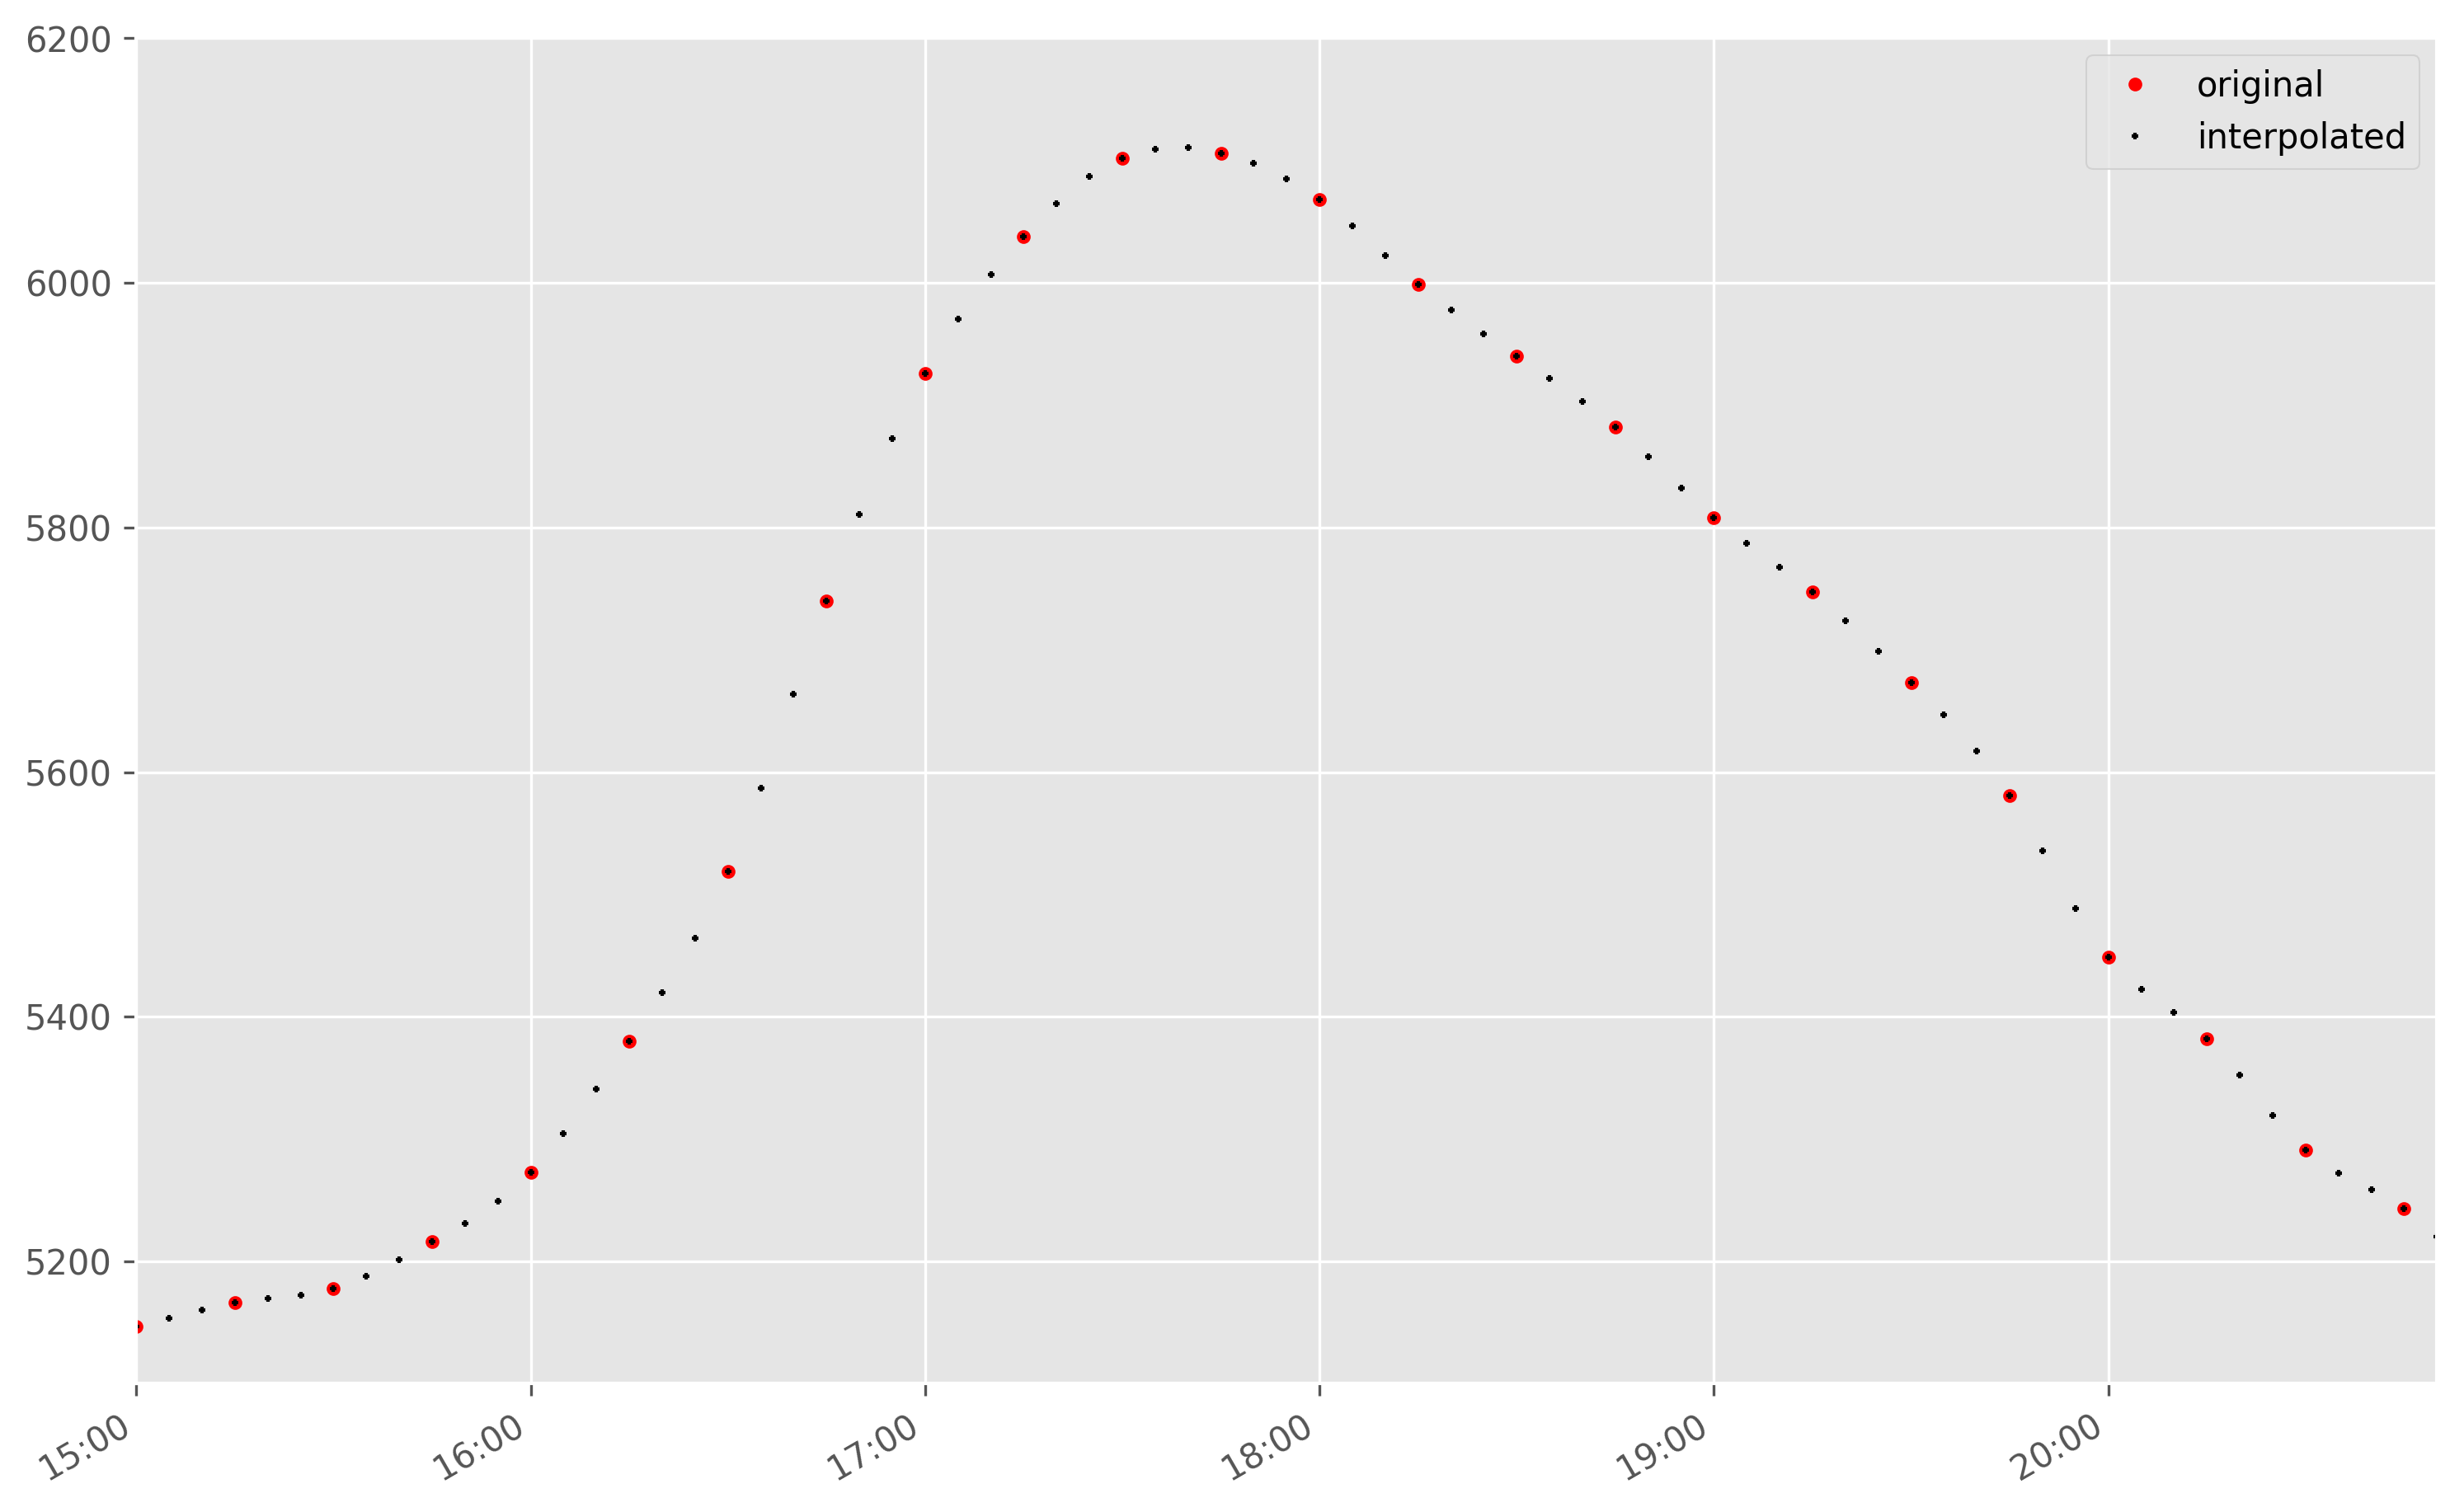

In [18]:
filename = "EirGridData050118.csv"

EirGridDate_i, EirGridValue_i = importEirGridCSV(
    filename, interpolation_factor=3, OUTPUT=True, report_interval=False)
# return interpolated results

EirGridDate, EirGridValue, original_interval = importEirGridCSV(
    filename, OUTPUT=True)

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

plt.plot(EirGridDate, EirGridValue, "ro", markersize=3, label="original")
plt.plot(
    EirGridDate_i, EirGridValue_i, "k+", markersize=2, label="interpolated")
plt.legend()

# format the ticks
myFmt = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
dataset_interval = EirGridDate_i[1] - EirGridDate_i[0]
#ax.set_xlim(EirGridDate_i[0], EirGridDate_i[-1] + dataset_interval)
ax.set_xlim(EirGridDate_i[180], EirGridDate_i[250])
ax.set_ylim(5100,6200)
plt.gcf().autofmt_xdate()

plt.savefig("InterpolationExampleZoomed.png")
plt.show()

# Project Spec

Battery Capacity stats:
https://en.wikipedia.org/wiki/Electric_vehicle_battery

From this I assume a 50kW battery pack as standard

There are over 2.5million cars on the irish roads
https://www.independent.ie/life/motoring/car-news/number-of-private-cars-on-our-roads-hits-two-million-34460268.html

Approx 2000 EV's on the road currently: https://www.thejournal.ie/electric-cars-ireland-1869259-Jan2015/

Avg Commute of 180km a week: https://www.thejournal.ie/commute-much-working-people-spend-eight-hours-a-week-travelling-187889-Jul2011/ or 26km a day
Nissan Leaf 40kW, EPA tested range of 117km, ie 2.925km / kW
Approx 9kW charge a day per car


In [8]:
BattPercUsage = 0.25
BatteryCapacity = 50 * (10**-3)
ProposedNumUsers = 100000.0
ExistingUsers = 2000
AvgDistTrav = 26  # kilometers


FILENAMES = ["EirGridData020718.csv", 'EirGridData050118.csv', 'EirGridData180218.csv', 'EirGridData250618.csv']

# Basic Range Reduction

				 _____      _     _   _____ _        _     _ _ _ _         
				|  __ \    (_)   | | /  ___| |      | |   (_) (_) |        
				| |  \/_ __ _  __| | \ `--.| |_ __ _| |__  _| |_| |_ _   _ 
				| | __| '__| |/ _` |  `--. \ __/ _` | '_ \| | | | __| | | |
				| |_\ \ |  | | (_| | /\__/ / || (_| | |_) | | | | |_| |_| |
				 \____/_|  |_|\__,_| \____/ \__\__,_|_.__/|_|_|_|\__|\__, |
				                                                      __/ |
				                                                     |___/ 
Data from 2018-07-02 imported successfully
Interpolation with factor: 2, completed successfully,
2018-07-02 POWER DEMAND STATS:
Peak Demand: 	4705.62 MW
Min Demand: 	2678.00 MW
Mean: 		3884.81 MW
Range: 		2027.62 MW
Total Usage: 	186.47 GWh

PROPOSED PLAN:
100,000 EV's w/ 50 kW packs connected to the grid, using 25% of their capacity
to support the Grid. Travelling an average of 26km per day, using 8.9 kWh
Available Capacity: 	1250 MWh
EV Charging Demand: 	2121 MWh

OUTCOME:
Peak Usa

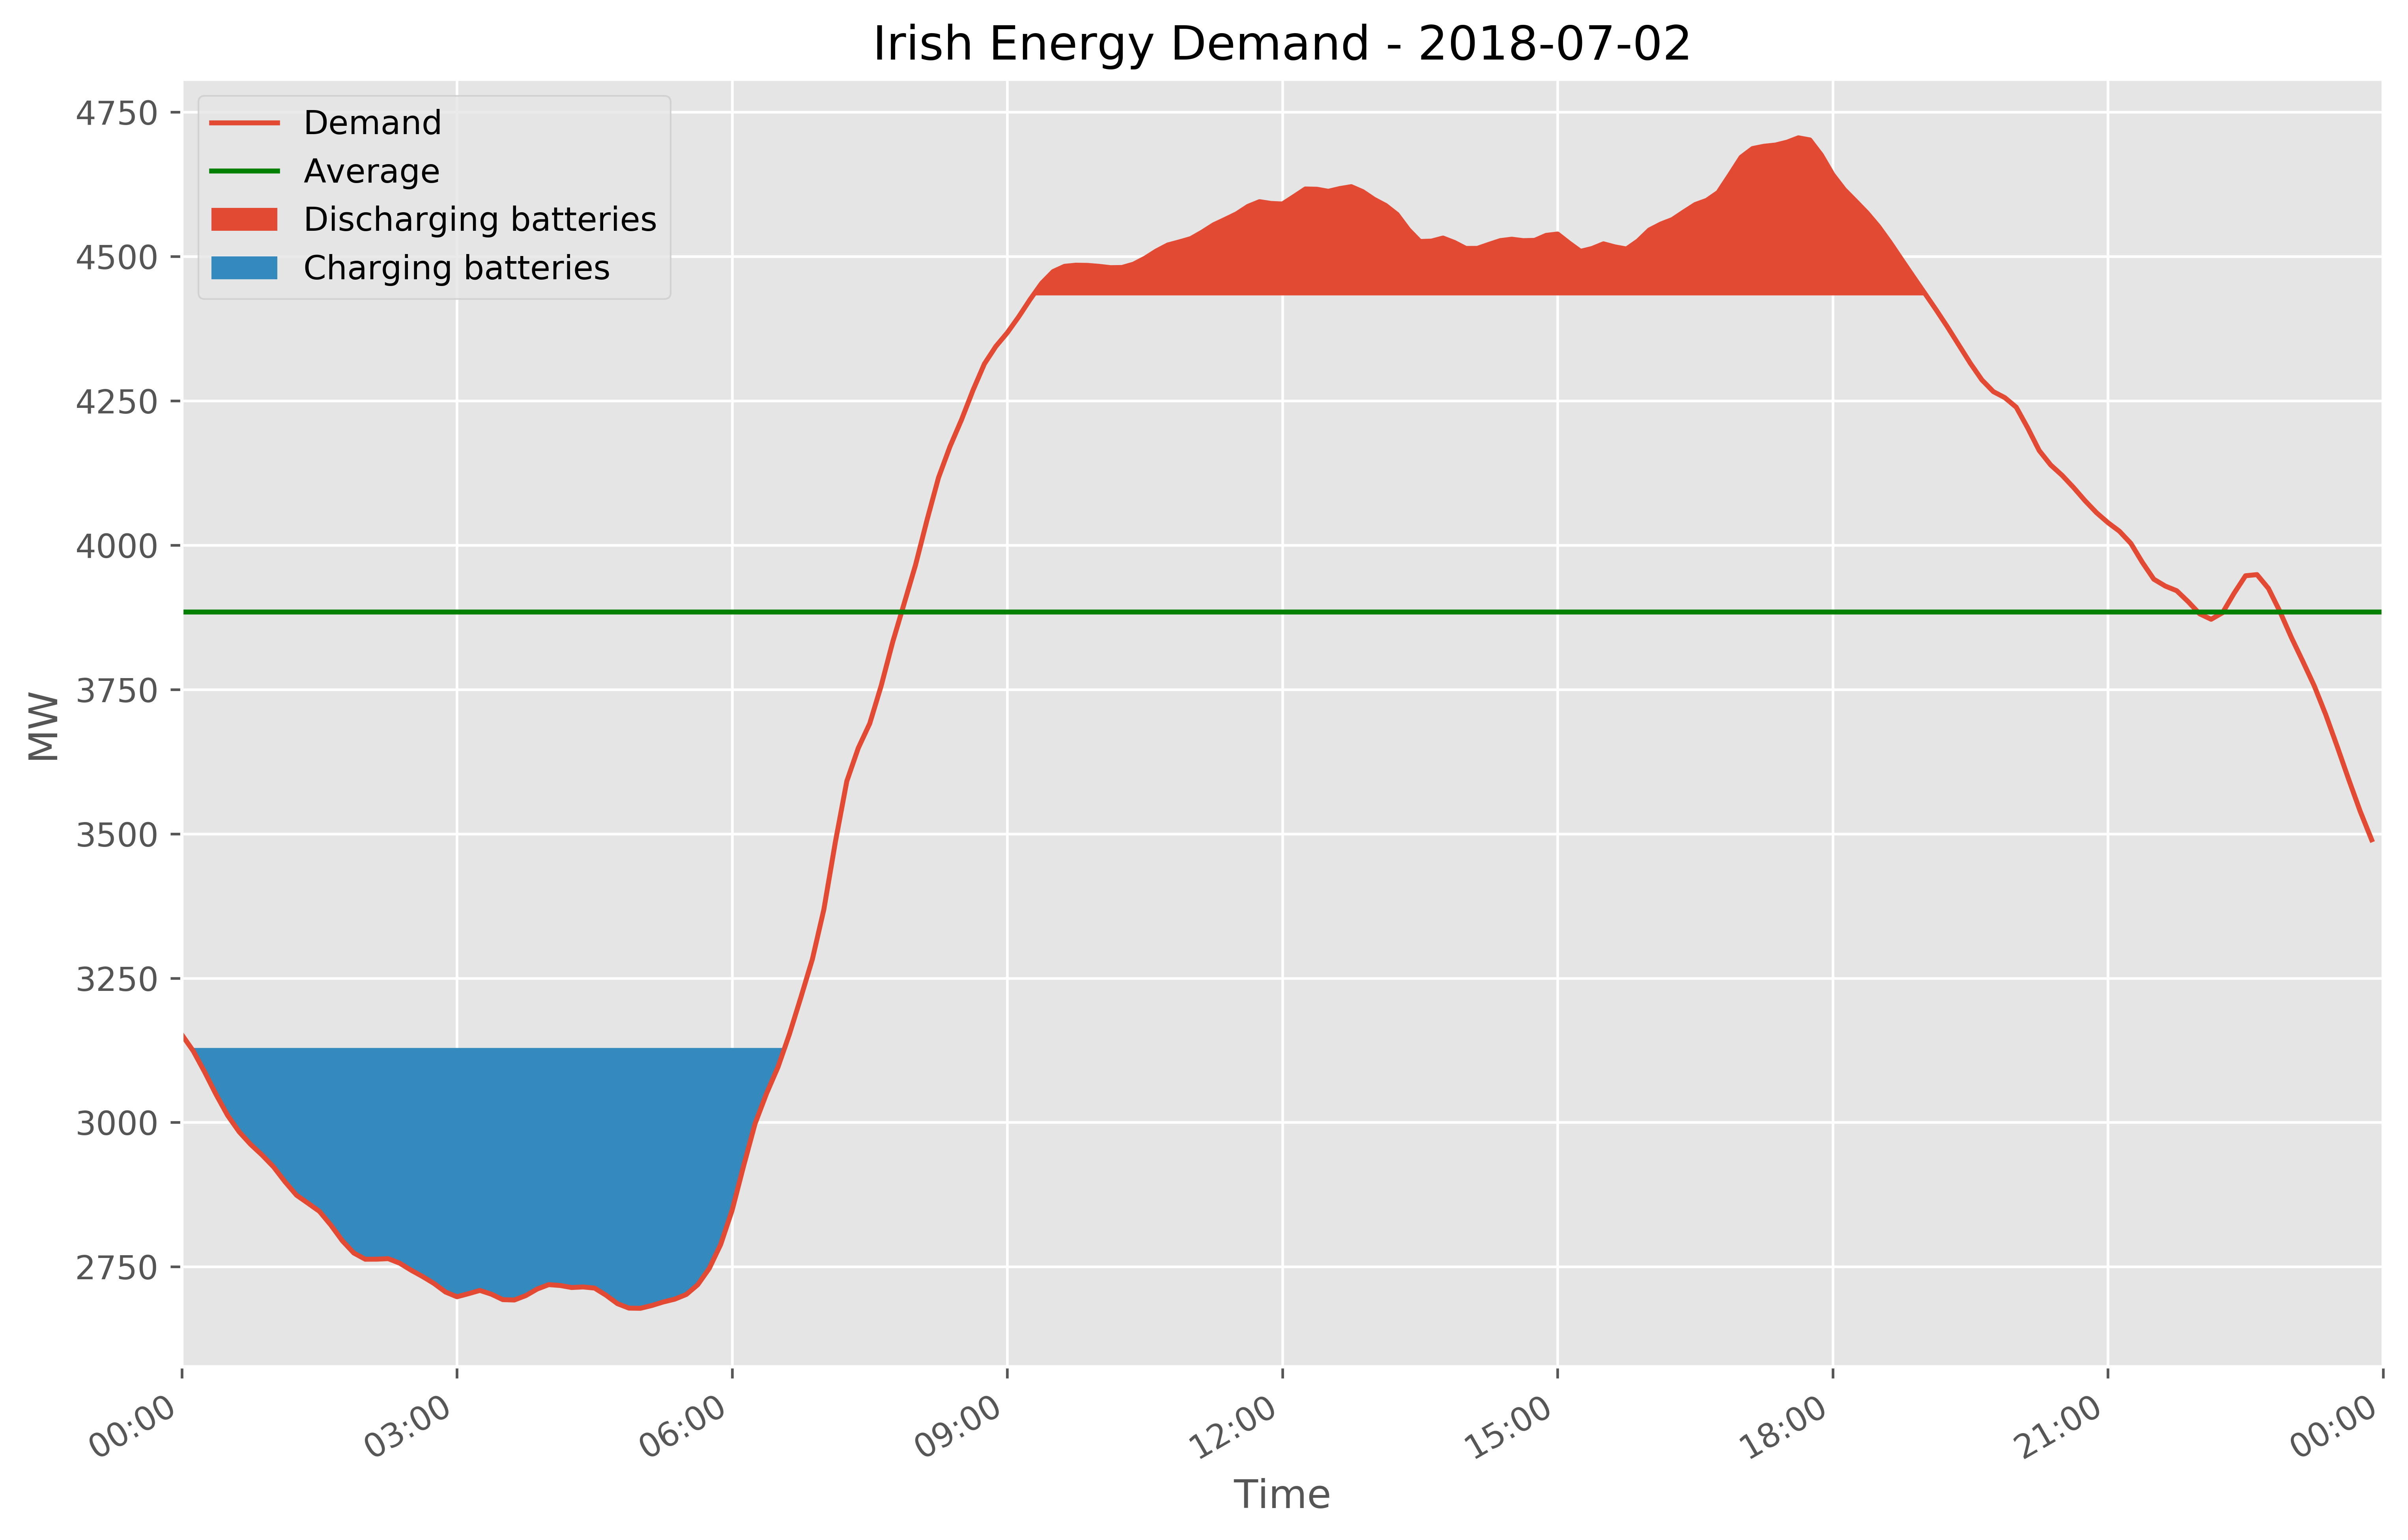

Data from 2018-01-05 imported successfully
Interpolation with factor: 2, completed successfully,
2018-01-05 POWER DEMAND STATS:
Peak Demand: 	6110.69 MW
Min Demand: 	3377.72 MW
Mean: 		4716.64 MW
Range: 		2732.97 MW
Total Usage: 	226.40 GWh

PROPOSED PLAN:
100,000 EV's w/ 50 kW packs connected to the grid, using 25% of their capacity
to support the Grid. Travelling an average of 26km per day, using 8.9 kWh
Available Capacity: 	1250 MWh
EV Charging Demand: 	2121 MWh

OUTCOME:
Peak Usage: 	5509.69 MW
Min Usage: 	3884.72 MW
Range: 		1624.97 MW 	Reduced by: 1108.00MW, 41%

ChargeTimes:
00:37:30 -> 06:45:00, Duration: 6:07:30 
DischargeTimes:
16:30:00 -> 20:00:00, Duration: 3:30:00 

Peak Power draw per EV: 6.01 kW
Max Charge rate per EV: 5.07 kW
Users Needed to flatline Demand Curve: 697,819
Saved File as: Truncated - Irish Energy Demand - 2018-01-05


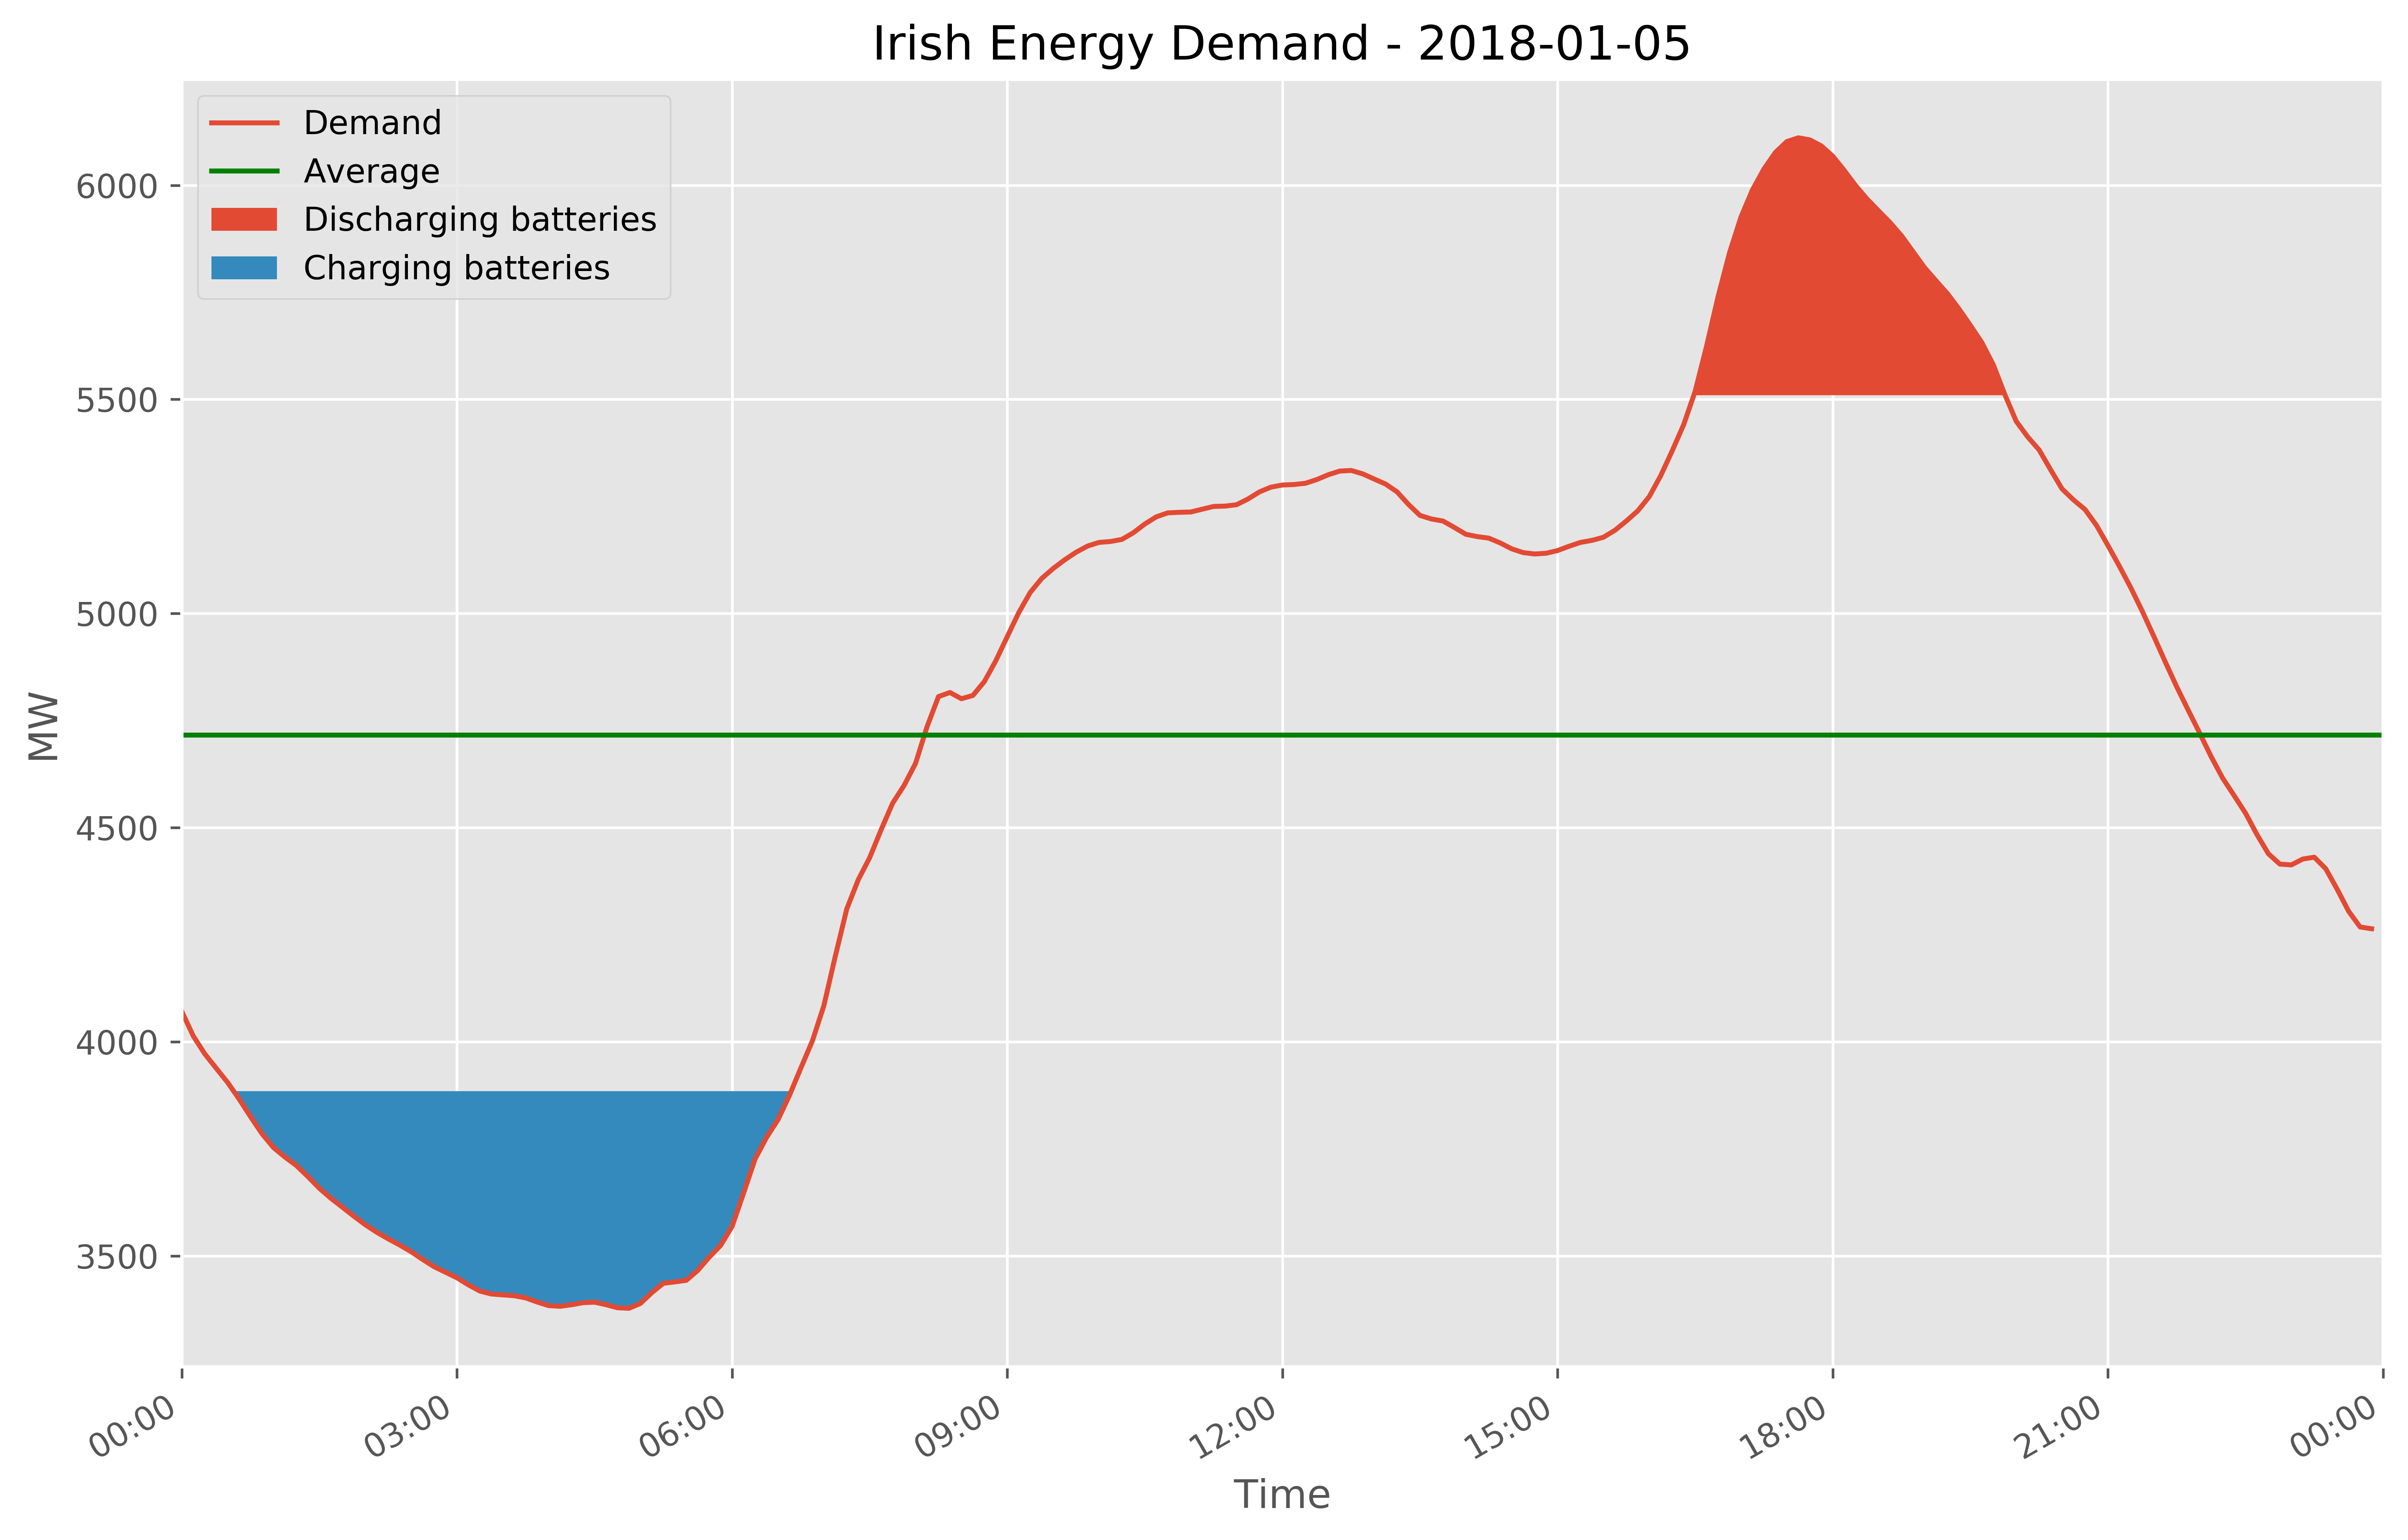

Data from 2018-06-19 imported successfully
Interpolation with factor: 2, completed successfully,
2018-06-19 POWER DEMAND STATS:
Peak Demand: 	5004.00 MW
Min Demand: 	2847.00 MW
Mean: 		4070.70 MW
Range: 		2157.00 MW
Total Usage: 	195.39 GWh

PROPOSED PLAN:
100,000 EV's w/ 50 kW packs connected to the grid, using 25% of their capacity
to support the Grid. Travelling an average of 26km per day, using 8.9 kWh
Available Capacity: 	1250 MWh
EV Charging Demand: 	2121 MWh

OUTCOME:
Peak Usage: 	4617.00 MW
Min Usage: 	3308.00 MW
Range: 		1309.00 MW 	Reduced by: 848.00MW, 39%

ChargeTimes:
00:15:00 -> 06:37:30, Duration: 6:22:30 
DischargeTimes:
09:07:30 -> 13:30:00, Duration: 4:22:30 14:07:30 -> 19:15:00, Duration: 5:07:30 

Peak Power draw per EV: 3.87 kW
Max Charge rate per EV: 4.61 kW
Users Needed to flatline Demand Curve: 649,596
Saved File as: Truncated - Irish Energy Demand - 2018-06-19


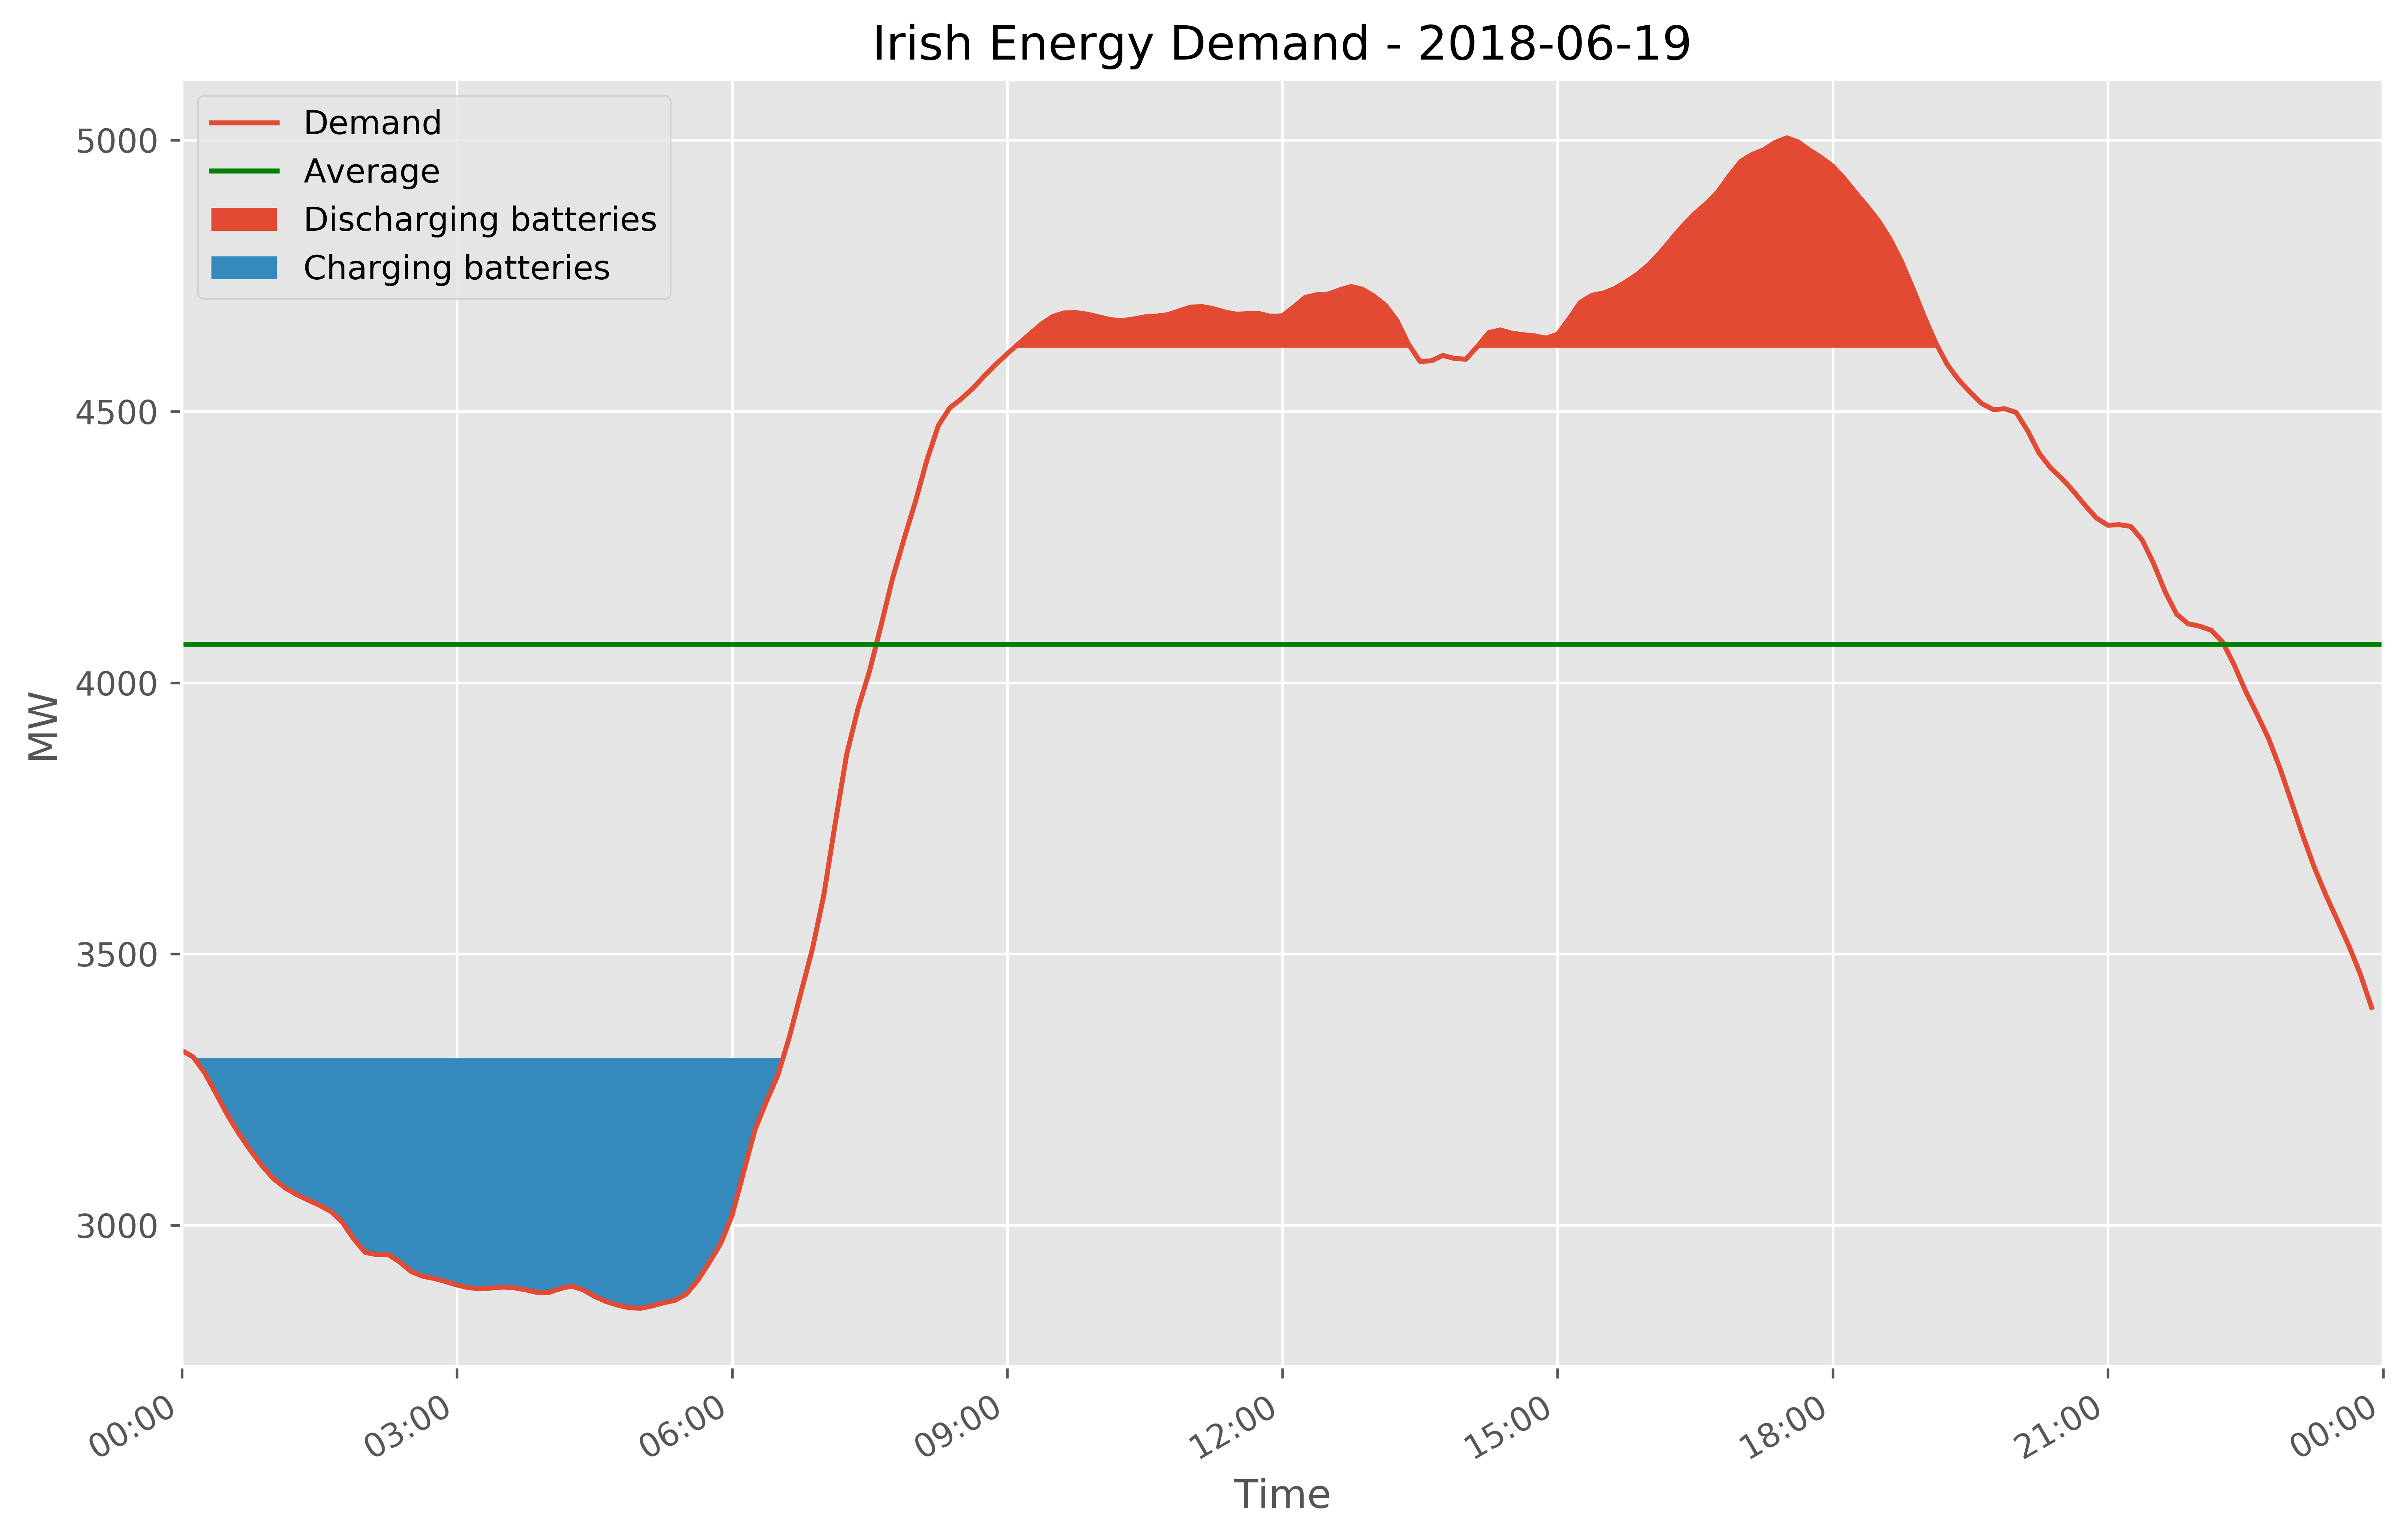

Data from 2018-06-25 imported successfully
Interpolation with factor: 2, completed successfully,
2018-06-25 POWER DEMAND STATS:
Peak Demand: 	4862.00 MW
Min Demand: 	2680.00 MW
Mean: 		3994.00 MW
Range: 		2182.00 MW
Total Usage: 	191.71 GWh

PROPOSED PLAN:
100,000 EV's w/ 50 kW packs connected to the grid, using 25% of their capacity
to support the Grid. Travelling an average of 26km per day, using 8.9 kWh
Available Capacity: 	1250 MWh
EV Charging Demand: 	2121 MWh

OUTCOME:
Peak Usage: 	4549.00 MW
Min Usage: 	3179.00 MW
Range: 		1370.00 MW 	Reduced by: 812.00MW, 37%

ChargeTimes:
00:15:00 -> 06:30:00, Duration: 6:15:00 
DischargeTimes:
09:07:30 -> 19:07:30, Duration: 10:00:00 

Peak Power draw per EV: 3.13 kW
Max Charge rate per EV: 4.99 kW
Users Needed to flatline Demand Curve: 656,013
Saved File as: Truncated - Irish Energy Demand - 2018-06-25


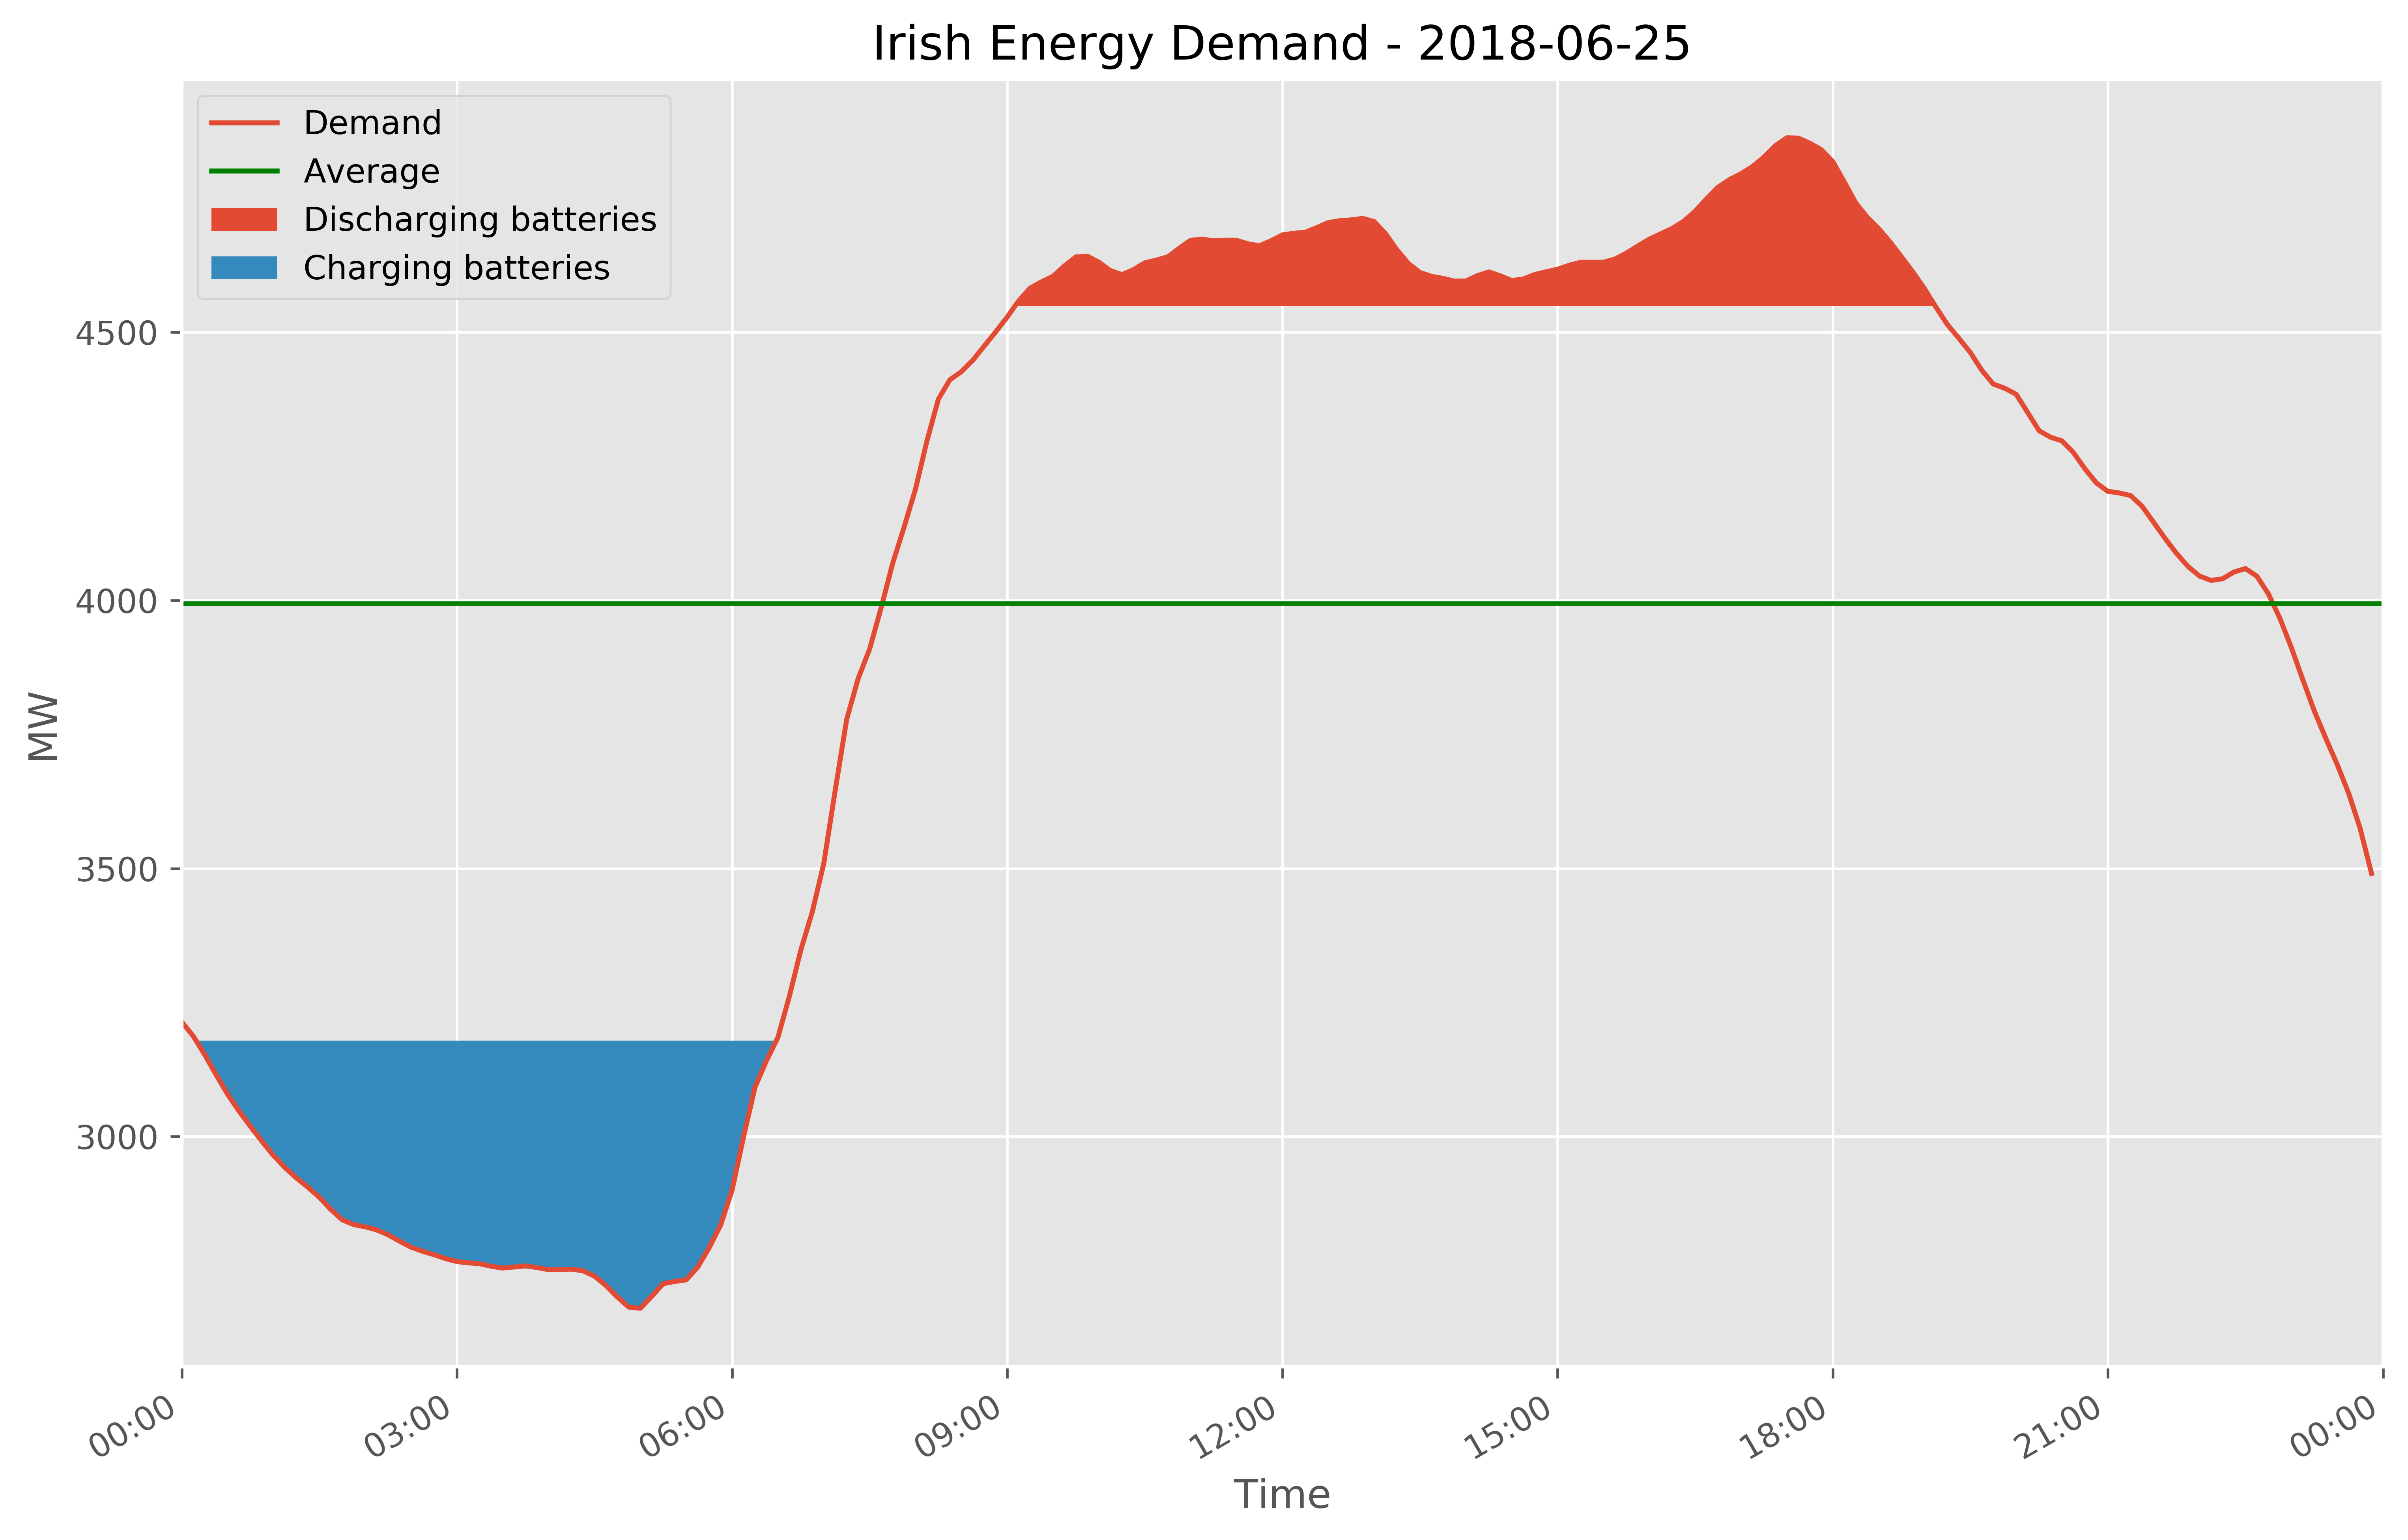

In [9]:
AsciiArt("Grid Stability")

for filename in FILENAMES:
    EvalBatteryProject(
        filename,
        BattPercUsage,
        BatteryCapacity,
        ProposedNumUsers,
        ExistingUsers,
        AvgDistTrav,
        interpolation_factor=2,
        FUNC_OUTPUT=False, save=True)

# Variance Reduction - "Smoothing"

Data from 2018-07-02 imported successfully

ORIGINAL:
Peak Demand: 	4702.00 MW
Min Demand: 	2678.00 MW
Range: 	2024.00 MW
Mean: 	3884.02 MW
Total: 	93.22 GWh

PROPOSED PLAN:
100,000 EV's w/ 50 kW packs connected to the grid, using 25% of their capacity
to support the Grid. Travelling an average of 26km per day, using 8.9 kWh
Available Capacity: 	1250 MWh
EV Charging Demand: 	2121 MWh

SMOOTHED:
Capacity Used for Smoothing: 	2639.31 MW, 	Unused Cap: 731.80 MW
Charging Capacity: 1319.65 MW, 	Discharging Capacity: 1319.65 MW
Peak Demand: 	4577.24 MW
Min Demand: 	2748.86 MW
Range: 	1828.38 MW
Mean: 	3884.02 MW
Total: 	93.22 GWh

Range Reduction: 195.62 MW, 10%
Saved File as: Smoothed - Irish Energy Demand - 2018-07-02


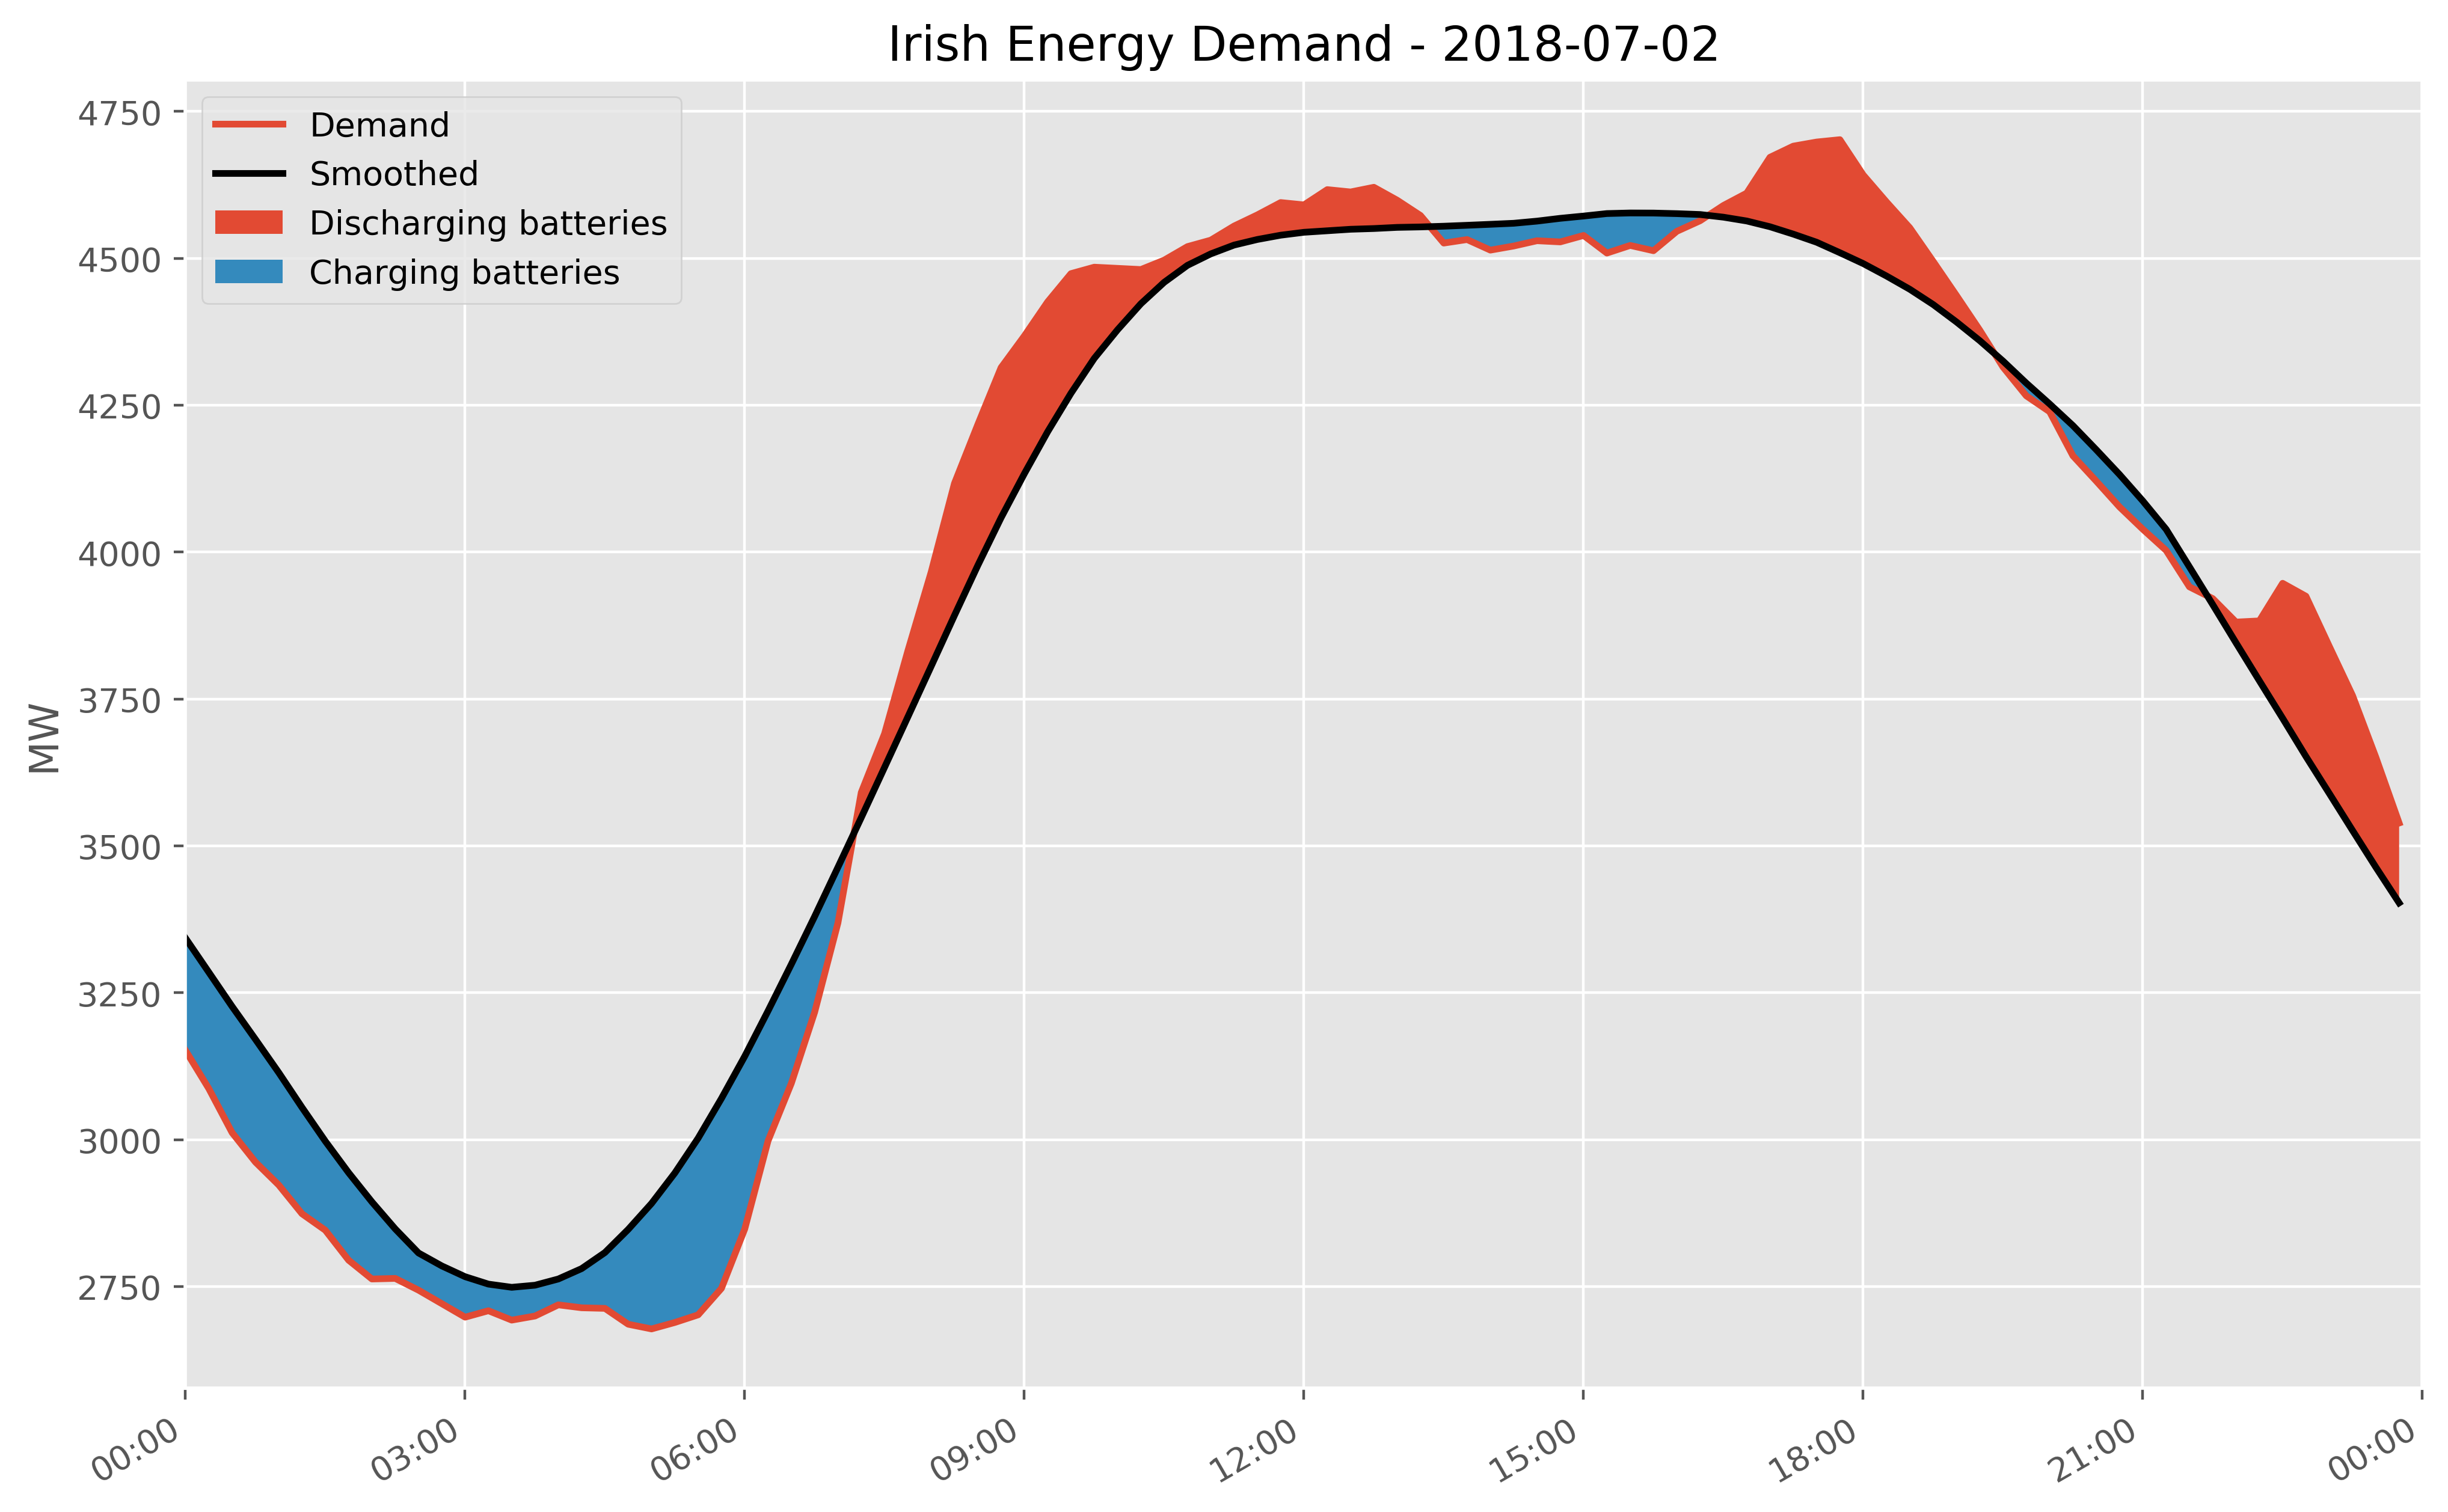

Data from 2018-01-05 imported successfully

ORIGINAL:
Peak Demand: 	6106.00 MW
Min Demand: 	3379.00 MW
Range: 	2727.00 MW
Mean: 	4716.21 MW
Total: 	113.19 GWh

PROPOSED PLAN:
100,000 EV's w/ 50 kW packs connected to the grid, using 25% of their capacity
to support the Grid. Travelling an average of 26km per day, using 8.9 kWh
Available Capacity: 	1250 MWh
EV Charging Demand: 	2121 MWh

SMOOTHED:
Capacity Used for Smoothing: 	2737.76 MW, 	Unused Cap: 633.35 MW
Charging Capacity: 1368.88 MW, 	Discharging Capacity: 1368.88 MW
Peak Demand: 	5731.79 MW
Min Demand: 	3469.63 MW
Range: 	2262.16 MW
Mean: 	4716.21 MW
Total: 	113.19 GWh

Range Reduction: 464.84 MW, 17%
Saved File as: Smoothed - Irish Energy Demand - 2018-01-05


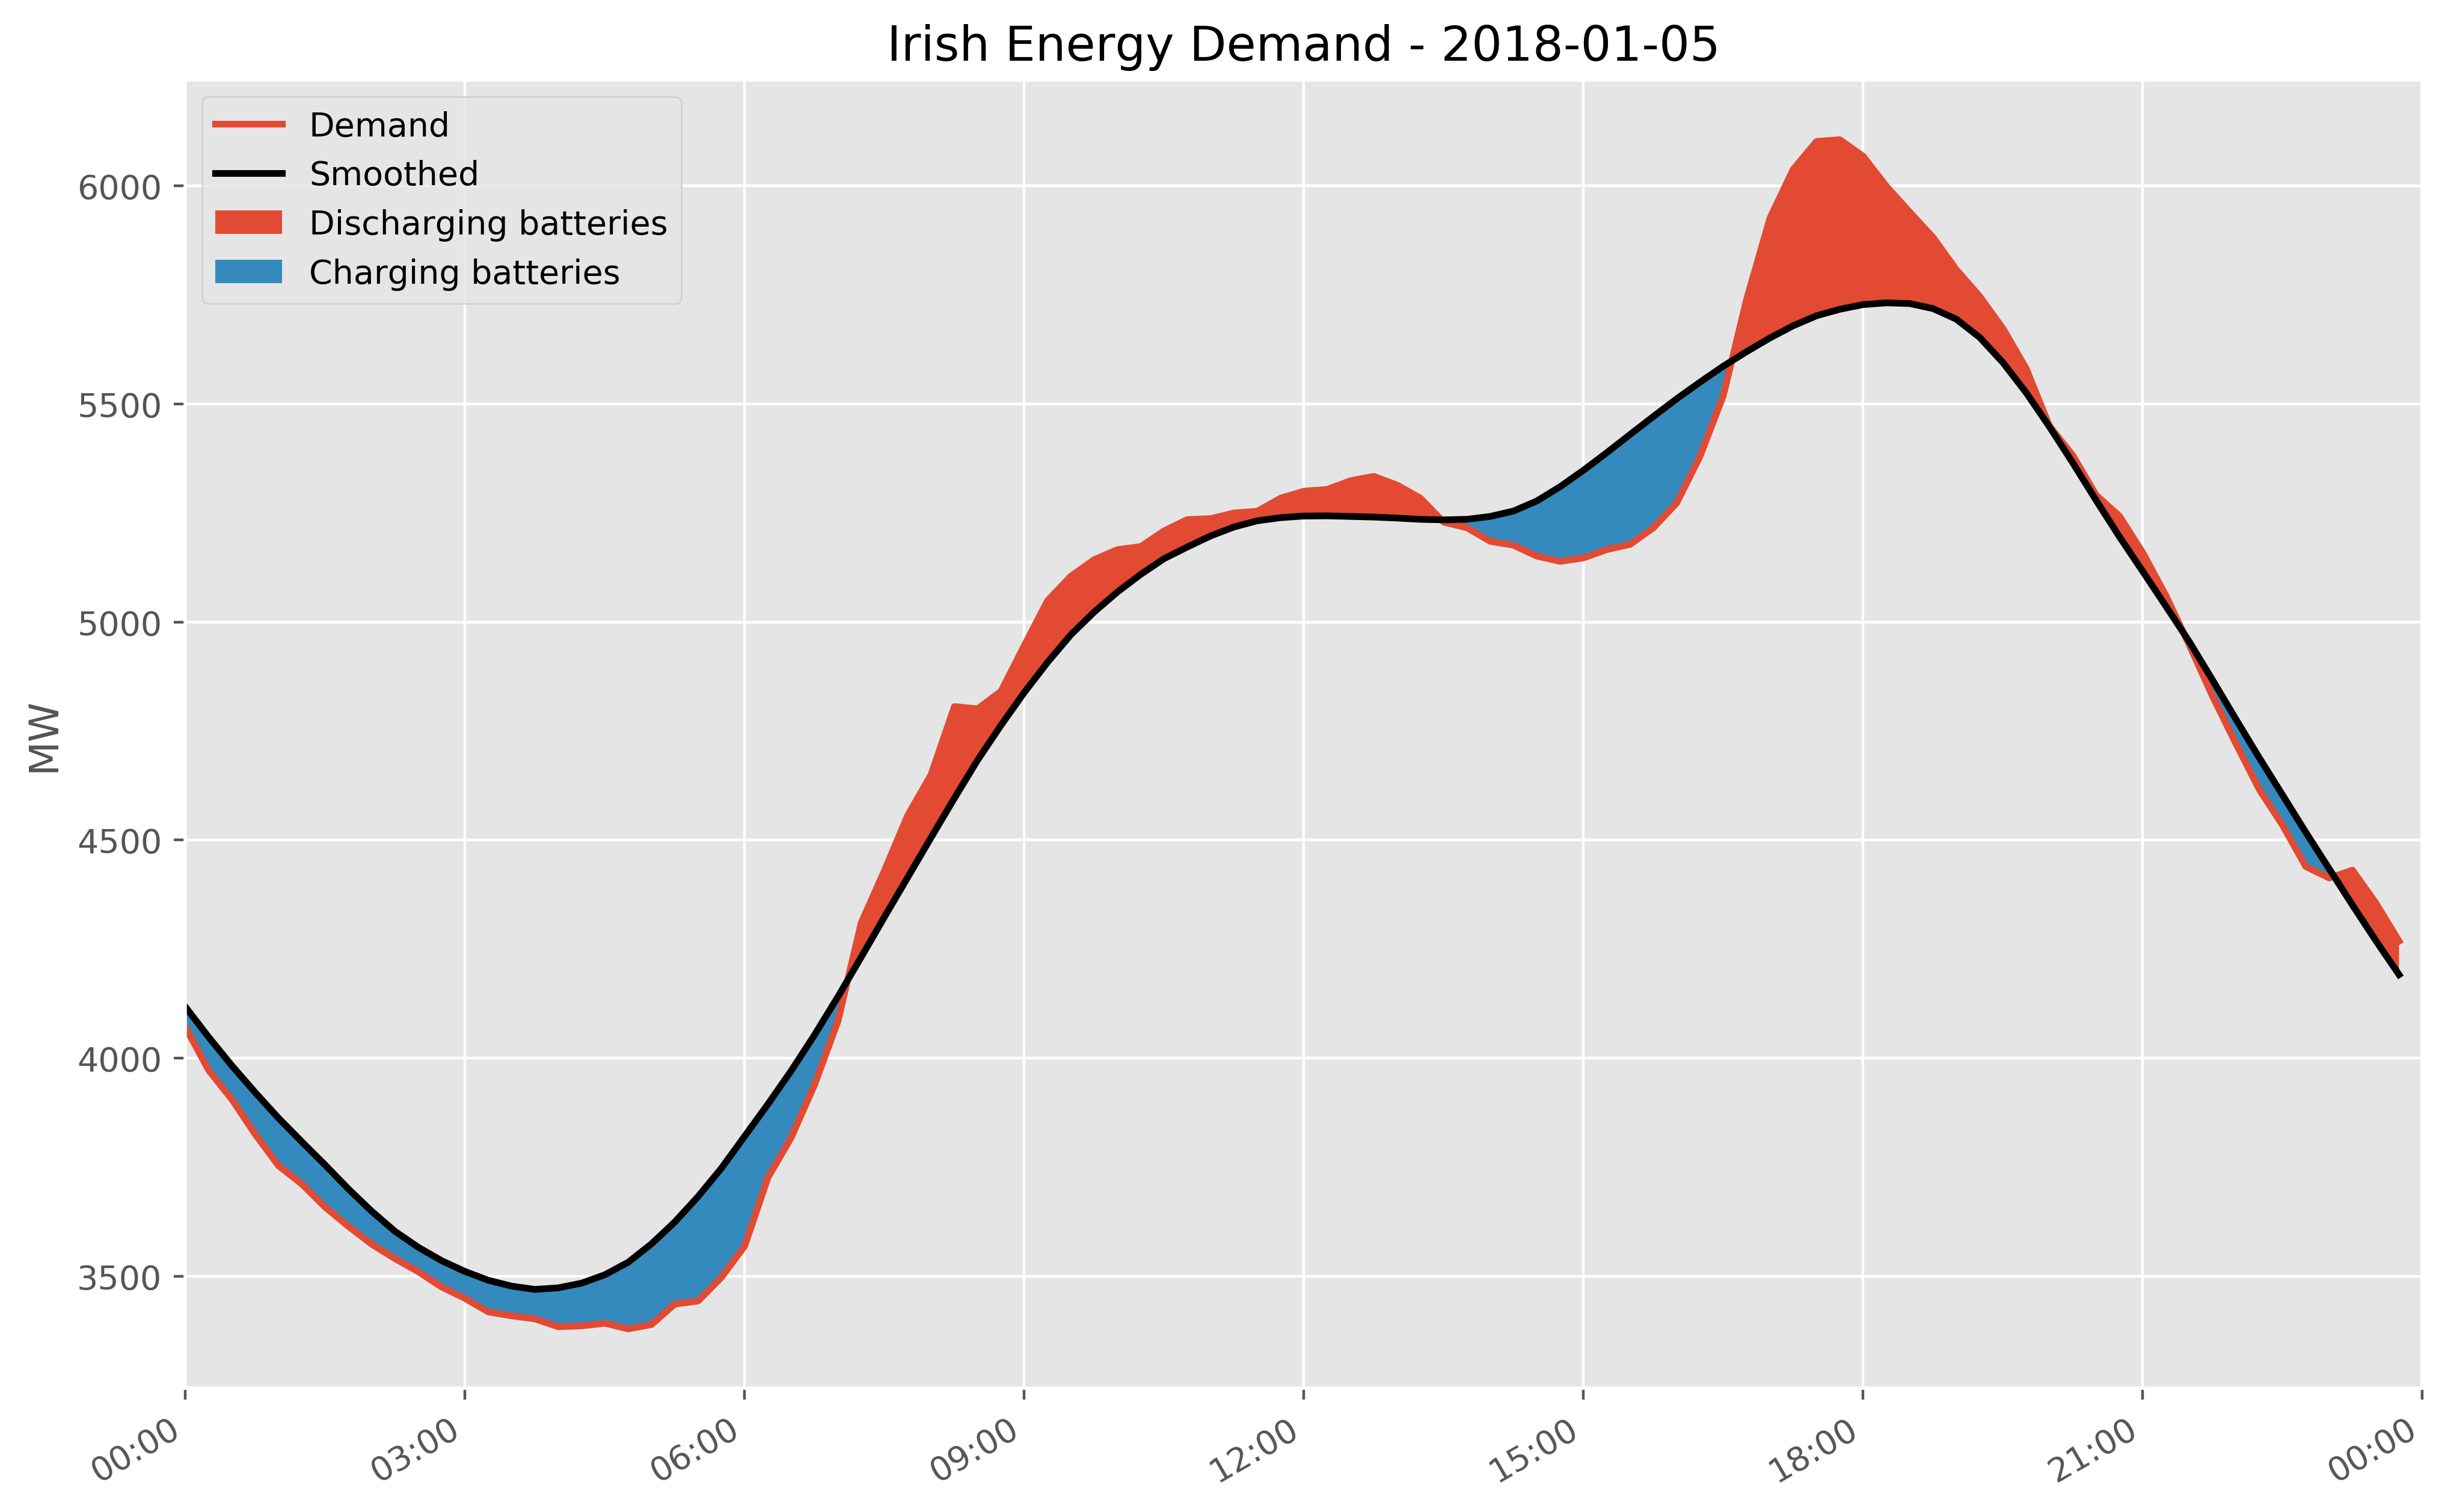

Data from 2018-06-19 imported successfully

ORIGINAL:
Peak Demand: 	5004.00 MW
Min Demand: 	2847.00 MW
Range: 	2157.00 MW
Mean: 	4070.58 MW
Total: 	97.69 GWh

PROPOSED PLAN:
100,000 EV's w/ 50 kW packs connected to the grid, using 25% of their capacity
to support the Grid. Travelling an average of 26km per day, using 8.9 kWh
Available Capacity: 	1250 MWh
EV Charging Demand: 	2121 MWh

SMOOTHED:
Capacity Used for Smoothing: 	2666.83 MW, 	Unused Cap: 704.28 MW
Charging Capacity: 1333.42 MW, 	Discharging Capacity: 1333.42 MW
Peak Demand: 	4798.48 MW
Min Demand: 	2926.24 MW
Range: 	1872.24 MW
Mean: 	4070.58 MW
Total: 	97.69 GWh

Range Reduction: 284.76 MW, 13%
Saved File as: Smoothed - Irish Energy Demand - 2018-06-19


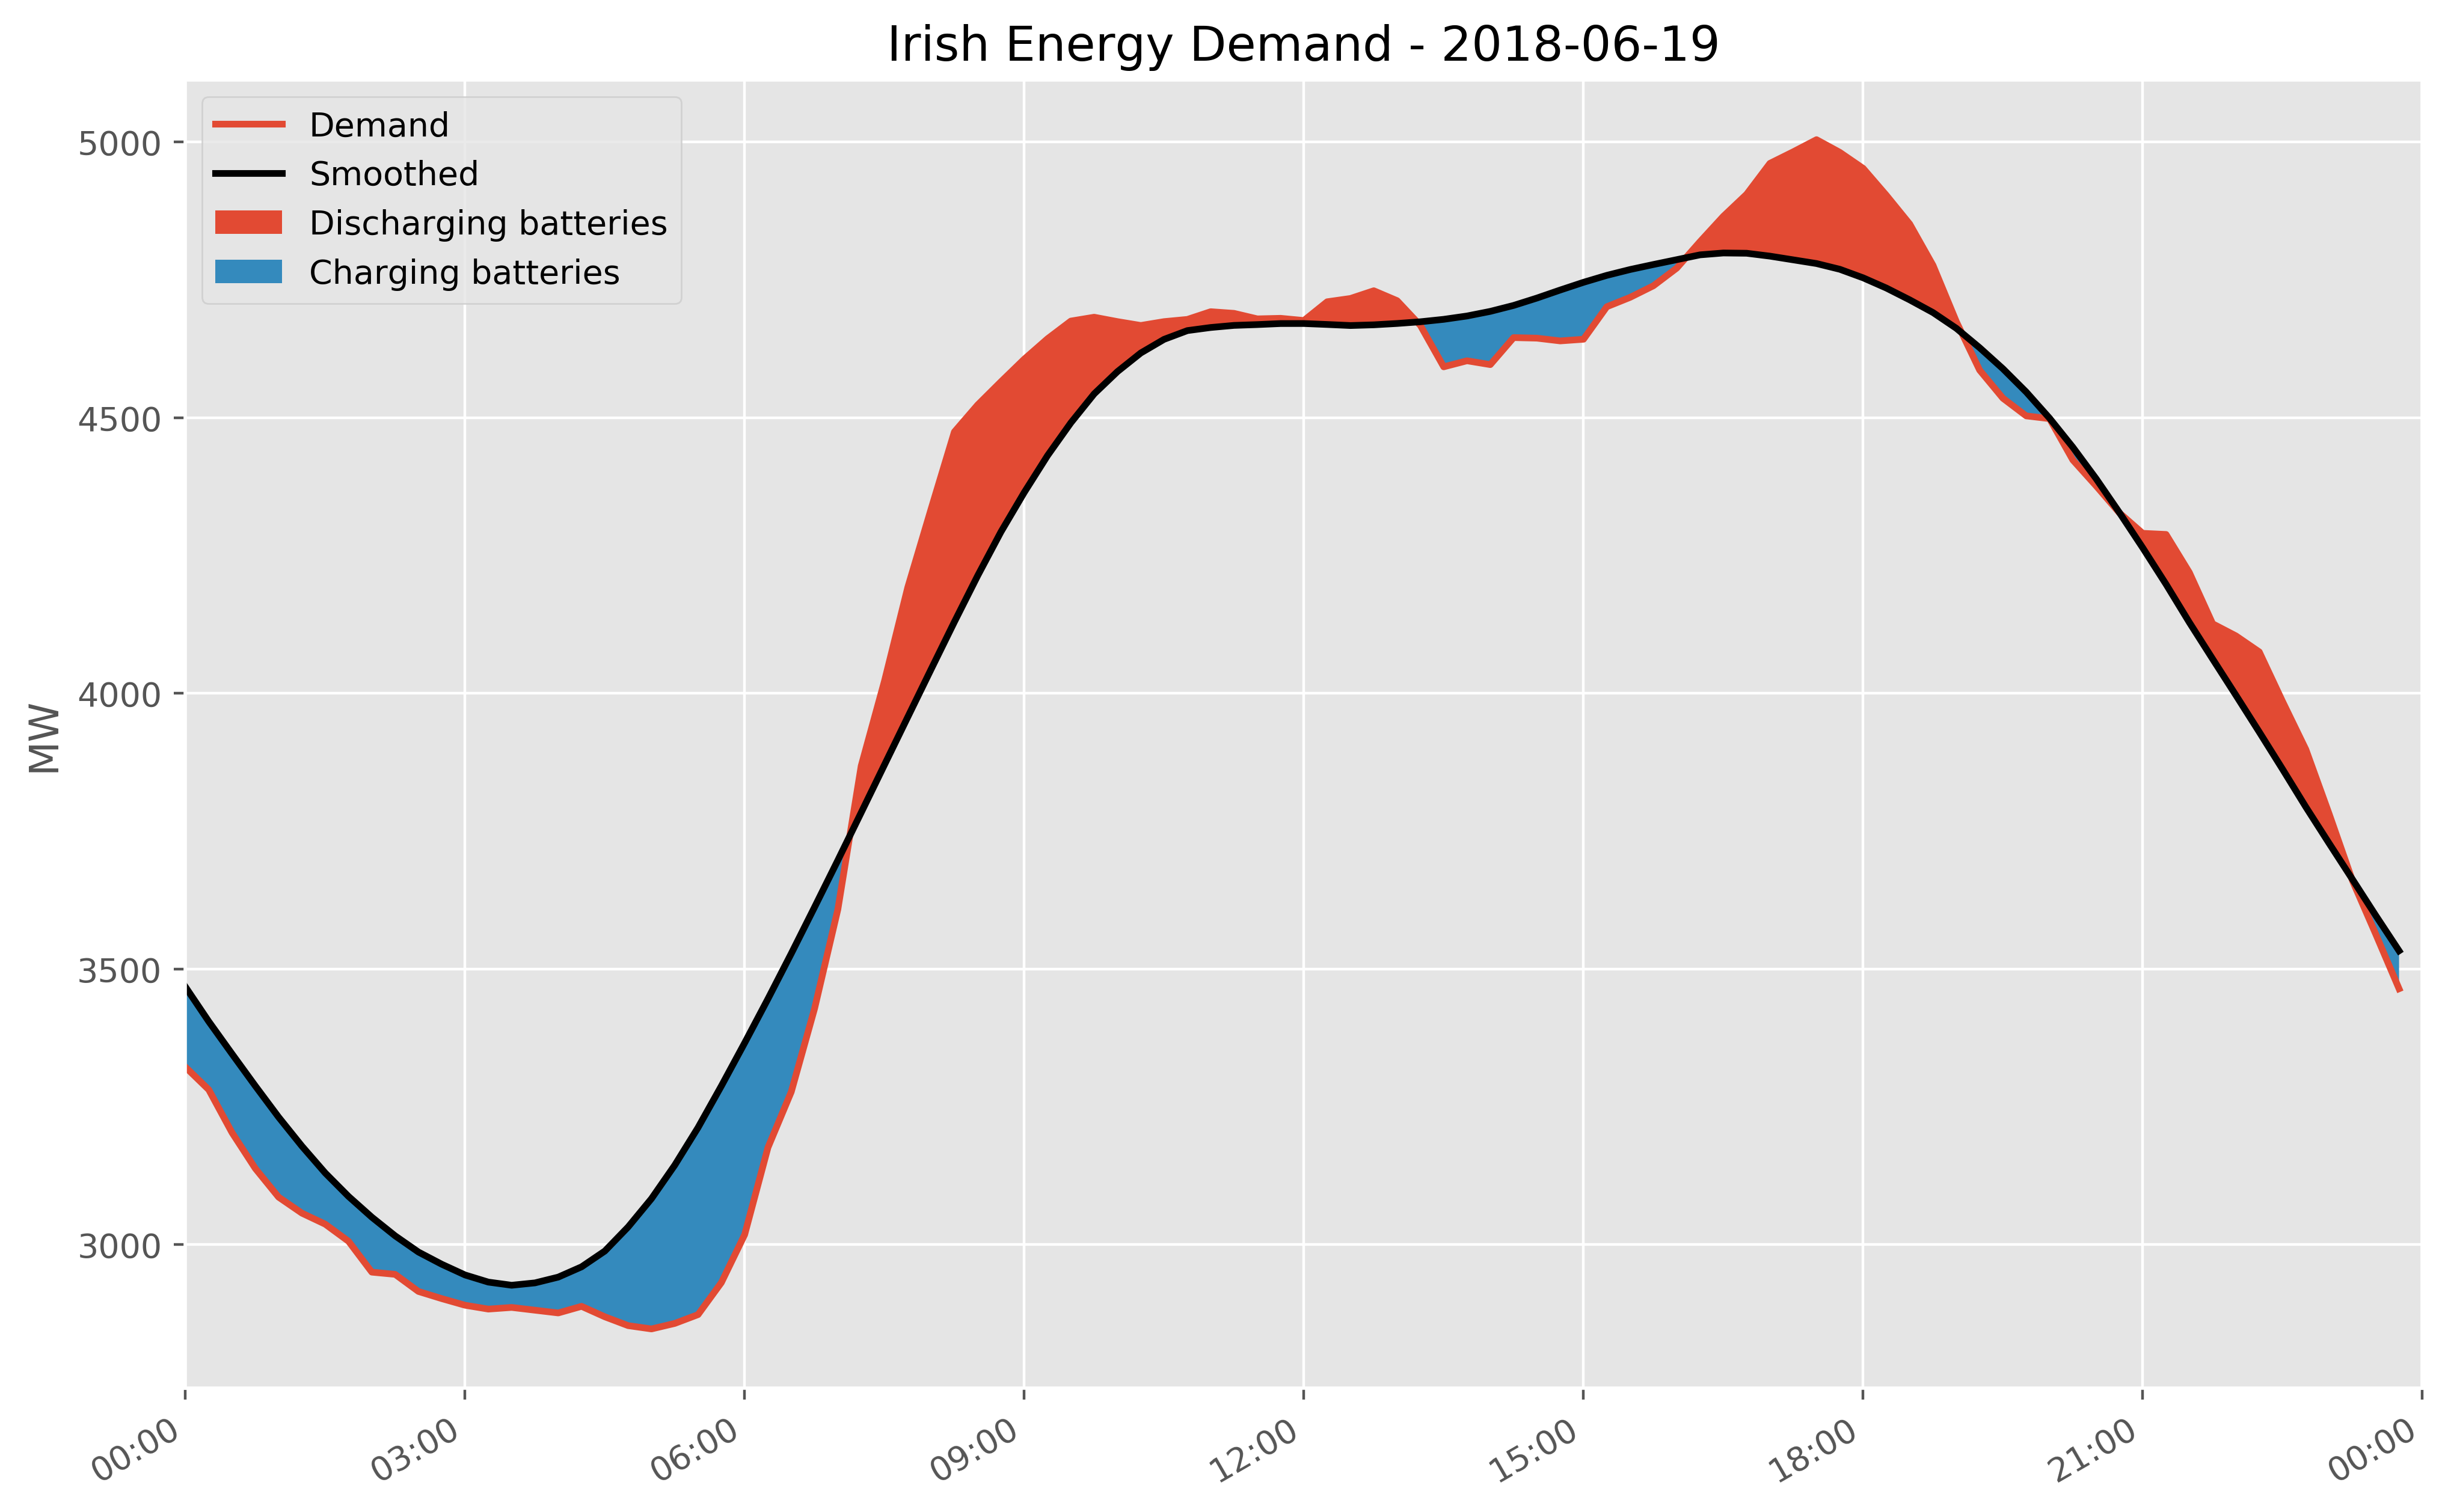

Data from 2018-06-25 imported successfully

ORIGINAL:
Peak Demand: 	4862.00 MW
Min Demand: 	2680.00 MW
Range: 	2182.00 MW
Mean: 	3993.43 MW
Total: 	95.84 GWh

PROPOSED PLAN:
100,000 EV's w/ 50 kW packs connected to the grid, using 25% of their capacity
to support the Grid. Travelling an average of 26km per day, using 8.9 kWh
Available Capacity: 	1250 MWh
EV Charging Demand: 	2121 MWh

SMOOTHED:
Capacity Used for Smoothing: 	2828.10 MW, 	Unused Cap: 543.02 MW
Charging Capacity: 1414.05 MW, 	Discharging Capacity: 1414.05 MW
Peak Demand: 	4696.29 MW
Min Demand: 	2793.57 MW
Range: 	1902.71 MW
Mean: 	3993.43 MW
Total: 	95.84 GWh

Range Reduction: 279.29 MW, 13%
Saved File as: Smoothed - Irish Energy Demand - 2018-06-25


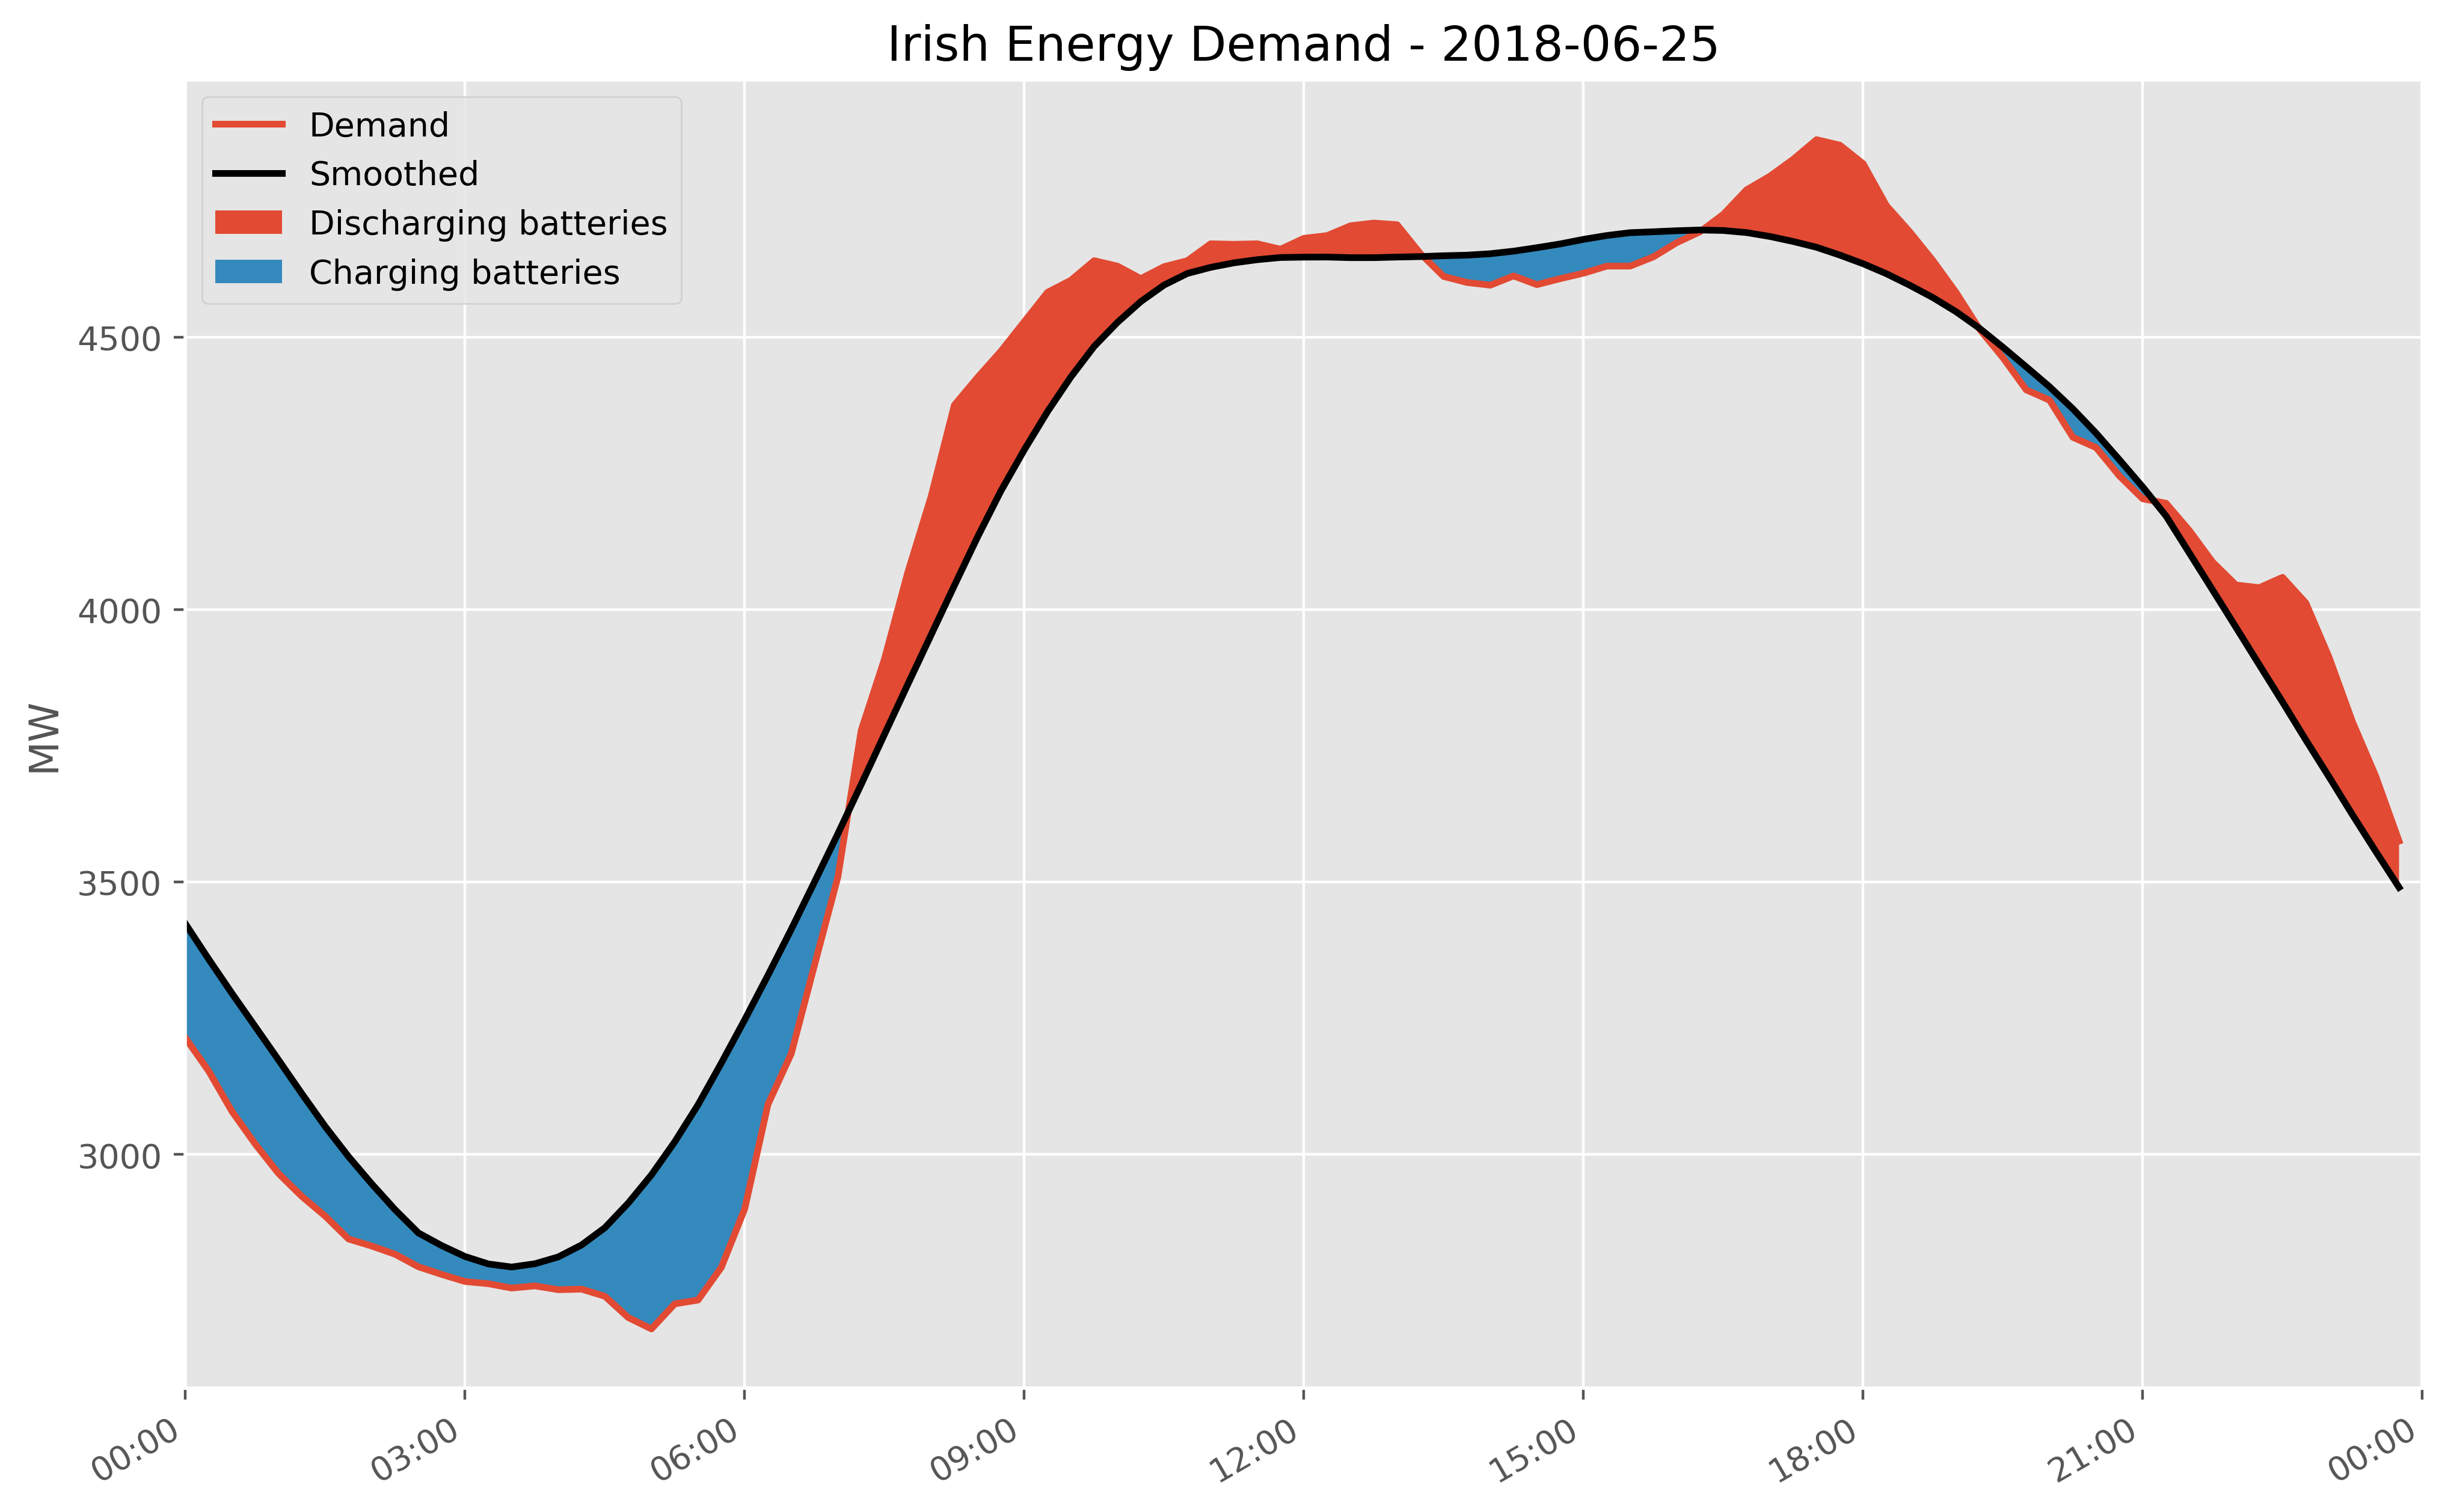

In [10]:
for filename in FILENAMES:
    SmoothDemandwBattProj(
        filename,
        BattPercUsage,
        BatteryCapacity,
        ProposedNumUsers,
        ExistingUsers,
        AvgDistTrav,
        interpolation_factor=1,
        FUNC_OUTPUT=False, save=False)